## End-to-End Workflow: LANL Red Team Detection and Analysis

### Step 1 – Load and Explore `redteam.txt`
Load the LANL red team ground truth file of confirmed compromise events (user/computer IDs, timestamps).  
- Read into DataFrame, name columns from documentation.  
- Add `day` and `time_hour` for temporal aggregation.  
- Convert IDs to categoricals to save memory.  
- Summarise active days, total events, unique users/computers, top entities.  
- Visualise:
  - Top 10 source computers (bar chart)  
  - Hourly event counts over dataset period  
- Store `redteam_days` and `redteam_span` for later filtering.

---

### Step 2 – Extract Authentication Events with Red Team Entities
Filter `auth.txt` to keep events where a red team user or computer is involved, on target days (8, 12, 13).  
- Build immutable sets of red team users/computers for fast lookup.  
- Define time windows in seconds for target days.  
- Stream through file, keeping:
  - Valid records (no `?`)  
  - Events within target days and involving a red team entity  
- Convert to categorical DataFrame; output total events.

---

### Step 3 – Analyse Red Team Authentication Events
Explore patterns in filtered events:  
1. **Basic stats** – total events, per day, success rate.  
2. **Memory footprint** – DataFrame size, unique IDs.  
3. **Entity roles** – red team *users* vs. legitimate users on red team *computers*.  
4. **Failures** – by day, user, computer.  
5. **Machine accounts** – detect via `$` suffix, check if red team.  
6. **Feature engineering** – add `hour`, `is_computer_account`.  
7. **Behaviour patterns** – failed-auth by hour, auth type breakdown, business vs. off-hours.  
8. **Potential anomalies** – high per-computer fail rate, concentrated NTLM failures.

---

### Step 4 – Host→Host View and Per-Computer Summary
Reduce auth stream to human-driven computer→computer interactions.  
1. Keep `src_computer != dst_computer`.  
2. Drop anonymous logons and machine accounts.  
3. Require a human user (`U\d+@DOM1`).  
4. Flag red team hosts.  
5. For each source computer: compute counts, success rate, auth-type entropy, mean events per destination, and log-scaled features.  
6. Compare red vs. normal host summaries.

---

### Step 5 – Build Graph and Basic Stats
From successful host→host events:  
- Create `DiGraph` with computers as nodes and auths as directed edges.  
- Add temporal fields for slicing.  
- Report:
  - Node/edge counts  
  - Min/mean/max degree (total, in, out)  
  - Clustering coefficient (undirected projection)  
  - Edge density  
- Plot log–log degree distribution to reveal hubs.

---

### Step 6 – SVD Scree and Embedding
- Sort nodes, build unweighted adjacency $A$.  
- Use truncated SVD for >85% sparsity, else full SVD.  
- Plot scree curve; elbows at $d \approx 5$ and $d \approx 10$.  
- Choose $d=5$, compute $X_{\text{svd}} = U_{:,1:d} \sqrt{\Sigma_{1:d}}$.

---

### Step 7a – Select Number of Clusters
Evaluate $k = 2$–9 on $d=5$ embedding:  
- K-Means inertia (elbow).  
- Silhouette score (peak = best separation).  
- GMM AIC/BIC (minima).  
- Suggest $k$ from each metric.

---

### Step 7b – Clustering and Entropy (k = 9)
- Fit K-Means and GMM; report silhouette scores.  
- Project to 2D via PCA for visualisation.  
- Left: K-Means clusters with numbered centres.  
- Right: GMM entropy, red team overlay, highlight top-50 entropy nodes.  
- Summarise red team proportion per cluster; plot entropy distribution.

---

### Step 8 – Anomaly Detection Pipeline
Encapsulate scoring, evaluation, and visualisation in `AnomalyDetector`:  
- **Scores:** K-Means distance, GMM log-likelihood, GMM entropy.  
- **Labels:** Red team membership.  
- **Metrics:** Precision/Recall at top-k and percentile thresholds, ROC AUC.  
- **Summaries:** Descriptive stats, red vs. non-red comparisons.  
- **Plots:** KDEs for K-Means/GMM scores; entropy KDE with inset.  
- **Workflow:** Initialise → run analysis → entropy plots → aggregate results.

---
---

In [32]:
# === Core Python & I/O Utilities ===
import os
import re
import random
import subprocess
from collections import Counter
from typing import Dict, List, Tuple, Optional

# === Progress Bars ===
from tqdm import tqdm

# === Data Handling ===
import numpy as np
import pandas as pd
import scipy.sparse as sp

# === Visualisation ===
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D

# === Graph Processing ===
import networkx as nx

# === Dimensionality Reduction & Normalisation ===
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize
from scipy.sparse.linalg import svds

# === Clustering Algorithms ===
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# === Evaluation Metrics ===
from sklearn.metrics import (
    auc as sklearn_auc,
    pairwise_distances,
    pairwise_distances_argmin_min,
    precision_score,
    recall_score,
    roc_auc_score,
    silhouette_score,
    precision_recall_curve
)
from scipy.stats import (
    entropy,
    ks_1samp,
    ks_2samp,
    uniform
)

# === Probabilistic Modelling ===
import pymc as pm
import pytensor.tensor as pt

In [33]:
# Seed for reproducability
np.random.seed(42)
random.seed(42)

## Step 1: Load `redteam.txt` and inspect it

First few rows:


,time,user,src_computer,dst_computer,day,time_hour
0,150885,U620@DOM1,C17693,C1003,1,41
1,151036,U748@DOM1,C17693,C305,1,41
2,151648,U748@DOM1,C17693,C728,1,42
3,151993,U6115@DOM1,C17693,C1173,1,42
4,153792,U636@DOM1,C17693,C294,1,42



Data types:
time               int64
user            category
src_computer    category
dst_computer    category
day                int64
time_hour          int64
dtype: object

Total red team events: 749
Time range: 150885 to 2557047 seconds since dataset epoch
Active days in dataset: [1, 2, 5, 6, 7, 8, 9, 12, 13, 14, 15, 20, 21, 22, 26, 27, 28, 29]

Red team activity count per day:
day
1      10
2      15
5      21
6       3
7       1
8     273
9      15
12    209
13     81
14     35
15     26
20      1
21      4
22      1
26     26
27      9
28      3
29     16
dtype: int64

Unique red team users: 104
Unique red team computers: 305

Top red team users by event count:
user
U66@DOM1      118
U3005@DOM1     36
U737@DOM1      32
U1653@DOM1     31
U293@DOM1      31
U748@DOM1      26
U1723@DOM1     19
U8946@DOM1     19
U3635@DOM1     18
U9947@DOM1     15
Name: count, dtype: int64

Top red team source computers by event count:
src_computer
C17693    701
C22409     26
C19932     19
C18025  

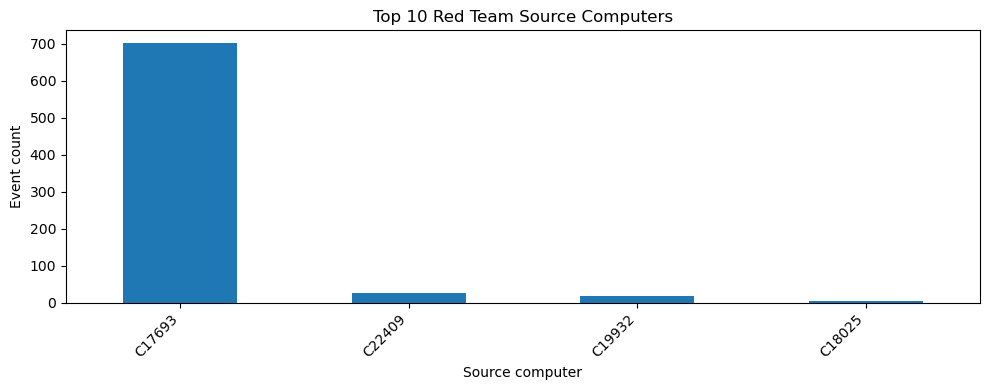

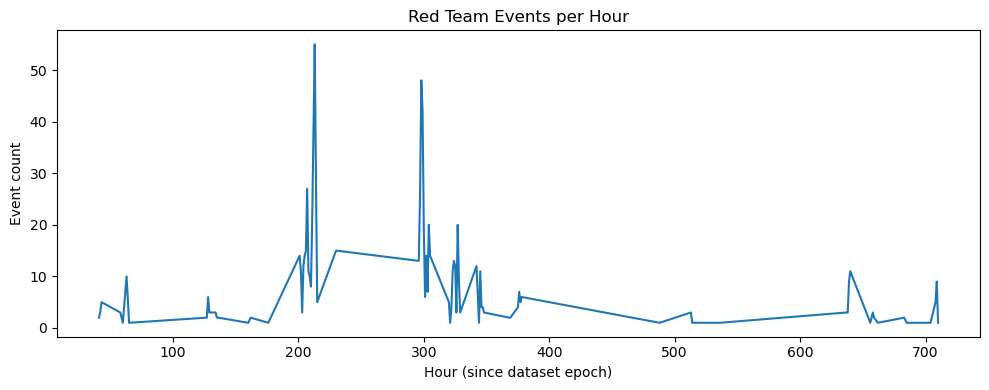

In [34]:
# Step 1: Load redteam.txt and inspect

# Define column names as per dataset documentation
red_cols = ["time", "user", "src_computer", "dst_computer"]

# Load (handles .txt or .gz)
df_red = pd.read_csv(
    "redteam.txt",
    names=red_cols,
    header=None,
    compression="infer",
    dtype={"time": "int64", "user": "string", "src_computer": "string", "dst_computer": "string"},
)

# Derive day/hour (LANL time is seconds since dataset epoch starting at 1)
df_red["day"] = df_red["time"] // 86400  # seconds per day
df_red["time_hour"] = df_red["time"] // 3600  # seconds per hour

# Optional memory optimisation for IDs
for col in ["user", "src_computer", "dst_computer"]:
    df_red[col] = df_red[col].astype("category")

# Sort chronologically
df_red = df_red.sort_values("time", kind="stable").reset_index(drop=True)

# Display basic info and summary statistics
print("First few rows:")
display(df_red.head())

print("\nData types:")
print(df_red.dtypes)

print(f"\nTotal red team events: {len(df_red)}")
print(f"Time range: {df_red['time'].min()} to {df_red['time'].max()} seconds since dataset epoch")
print(f"Active days in dataset: {sorted(df_red['day'].unique().tolist())}")

print("\nRed team activity count per day:")
print(df_red.groupby("day").size().sort_index())

# Unique red team users and computers
red_users = df_red["user"].cat.categories if hasattr(df_red["user"], "cat") else df_red["user"].unique()
red_computers = pd.unique(df_red[["src_computer", "dst_computer"]].values.ravel())

print(f"\nUnique red team users: {df_red['user'].nunique()}")
print(f"Unique red team computers: {len(red_computers)}")

# Top users
top_users = df_red["user"].value_counts().head(10)
print("\nTop red team users by event count:")
print(top_users)

# Top sources
src_counts = df_red["src_computer"].value_counts()
print("\nTop red team source computers by event count:")
print(src_counts.head(10))

# Plot top 10 source computers
plt.figure(figsize=(10, 4))
src_counts.head(10).plot(kind="bar", title="Top 10 Red Team Source Computers")
plt.ylabel("Event count")
plt.xlabel("Source computer")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Plot hourly count of red team events over time
plt.figure(figsize=(10, 4))
df_red.groupby("time_hour").size().plot(title="Red Team Events per Hour")
plt.xlabel("Hour (since dataset epoch)")
plt.ylabel("Event count")
plt.tight_layout()
plt.show()

# Store summary variables for later use
redteam_days = sorted(df_red["day"].unique().tolist())
redteam_span = (int(df_red["time"].min()), int(df_red["time"].max()))

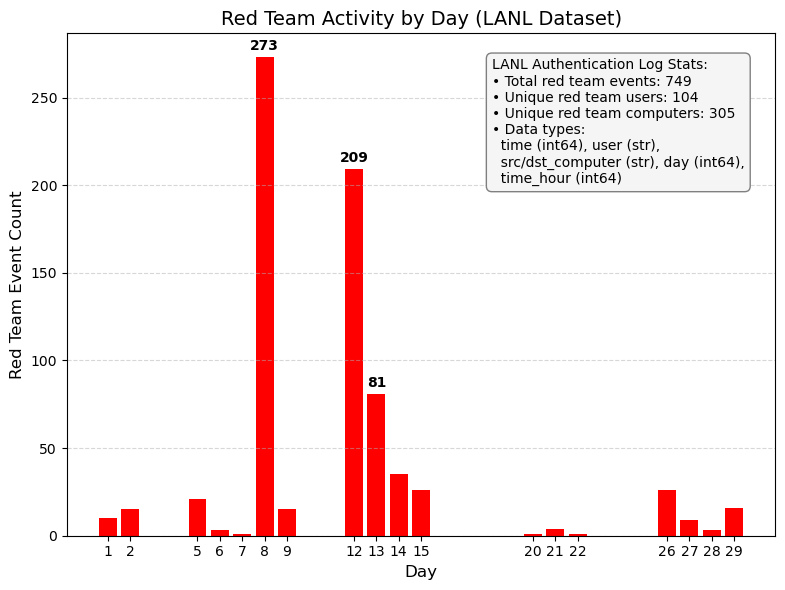

num_users:  81
num_computers:  268


In [35]:
# Red team activity count per day
red_team_activity = {
    1: 10,
    2: 15,
    5: 21,
    6: 3,
    7: 1,
    8: 273,
    9: 15,
    12: 209,
    13: 81,
    14: 35,
    15: 26,
    20: 1,
    21: 4,
    22: 1,
    26: 26,
    27: 9,
    28: 3,
    29: 16
}

# Create a DataFrame
df = pd.DataFrame(list(red_team_activity.items()), columns=["Day", "Event Count"])
df.sort_values("Day", inplace=True)

# Plot
plt.figure(figsize=(8, 6))
bars = plt.bar(df["Day"], df["Event Count"], color="red")

# Annotate top days
for bar in bars:
    height = bar.get_height()
    if height > 80:
        plt.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 5), textcoords="offset points", ha='center', fontsize=10, fontweight='bold')

# Add custom legend box with dataset metadata
legend_text = (
    "LANL Authentication Log Stats:\n"
    "• Total red team events: 749\n"
    "• Unique red team users: 104\n"
    "• Unique red team computers: 305\n"
    "• Data types:\n"
    "  time (int64), user (str),\n"
    "  src/dst_computer (str), day (int64),\n"
    "  time_hour (int64)"
)
plt.text(0.60, 0.95, legend_text, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.4', facecolor='whitesmoke', edgecolor='gray'))

plt.title("Red Team Activity by Day (LANL Dataset)", fontsize=14)
plt.xlabel("Day", fontsize=12)
plt.ylabel("Red Team Event Count", fontsize=12)
plt.xticks(df["Day"])
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

subset = df_red[df_red['day'].isin([8, 12, 13])]
num_users = subset['user'].nunique()
num_computers = pd.concat([subset['src_computer'], subset['dst_computer']]).nunique()
print("num_users: ", num_users)
print("num_computers: ", num_computers)

## Step 2: Streaming `auth.txt` Based on Ted Team Results

In [37]:
# Step 1: Get red team entities (as immutable sets for faster lookup)
red_users = frozenset(df_red["user"])
red_computers = frozenset(df_red["src_computer"]).union(df_red["dst_computer"])

# Step 2: Define time windows (seconds since dataset epoch)
DAY_SECONDS = 86400
target_days = [8, 12, 13]
day_windows = [(d * DAY_SECONDS, (d + 1) * DAY_SECONDS) for d in target_days]
max_time_cutoff = (max(target_days) + 1) * DAY_SECONDS

# Step 3: Authentication event columns (LANL auth.txt format)
auth_cols = [
    "time", "src_user", "dst_user",
    "src_computer", "dst_computer",
    "auth_type", "logon_type", "auth_orientation", "success"
]

filtered_rows = []

# Step 4: Stream through auth.txt line by line
with open("auth.txt", "r") as f:
    for line in tqdm(f, desc="Processing auth.txt"):
        parts = line.strip().split(",")

        # Skip malformed lines or those with unknown values ("?")
        if len(parts) != len(auth_cols) or "?" in parts:
            continue

        row = dict(zip(auth_cols, parts))
        row["time"] = int(row["time"])

        # Stop once beyond max day of interest
        if row["time"] >= max_time_cutoff:
            break

        # Keep only events within target days
        if not any(start <= row["time"] < end for start, end in day_windows):
            continue

        # Keep if any red team entity is involved
        if (
            row["src_user"] in red_users or
            row["dst_user"] in red_users or
            row["src_computer"] in red_computers or
            row["dst_computer"] in red_computers
        ):
            filtered_rows.append(row)

# Step 5: Convert to DataFrame and optimise types
auth_df = pd.DataFrame(filtered_rows)
auth_df["time"] = auth_df["time"].astype(np.int64)
auth_df["success"] = auth_df["success"].astype("category")  # or .astype(bool) if needed
for col in ["src_user", "dst_user", "src_computer", "dst_computer"]:
    auth_df[col] = auth_df[col].astype("category")

print(f"Filtered authentication events for days {target_days}: {len(auth_df)}")

Processing auth.txt: 239471461it [06:35, 605869.16it/s]


Filtered authentication events for days [8, 12, 13]: 19967243


## Step 3: Basic EDA

In [38]:
# --- 1. Total events and success rate ---
print(f"Total events filtered: {len(auth_df)}")
print(f"Events per day: {auth_df.groupby(auth_df['time'] // DAY_SECONDS).size()}")
print(f"Success rate: {auth_df['success'].value_counts(normalize=True)}")

# --- 2. Memory usage + unique computers/users ---
print(f"\nDataFrame memory usage: {auth_df.memory_usage(deep=True).sum() / 1024**3:.2f} GB")
print(f"Unique users: {auth_df['src_user'].nunique() + auth_df['dst_user'].nunique()}")
print(f"Unique computers: {auth_df['src_computer'].nunique() + auth_df['dst_computer'].nunique()}")

# --- 3. Check how much is actual red team vs normal activity involving these entities ---
red_user_events = auth_df[
    auth_df['src_user'].isin(red_users) | auth_df['dst_user'].isin(red_users)
]

red_computer_only = auth_df[~(
    auth_df['src_user'].isin(red_users) | auth_df['dst_user'].isin(red_users)
)]

print(f"\nRed team USER activity: {len(red_user_events):,} events")
print(f"Red team COMPUTER activity (legit users): {len(red_computer_only):,} events")

# --- 4. Analyse failed authentications more closely ---
failed_auths = auth_df[auth_df['success'] == 'Fail']
print(f"\nFailed authentication events: {len(failed_auths)}")
print("Failed auth breakdown by day:")
print(failed_auths.groupby(failed_auths['time'] // DAY_SECONDS).size())

# --- 5. Check if failures are concentrated on specific users/computers ---
print("\nTop users with failed auths:")
print(failed_auths['src_user'].value_counts().head())
print("\nTop computers with failed auths:")
print(failed_auths['src_computer'].value_counts().head())

# --- 6. Analyse this pattern further ---
computer_accounts = failed_auths[failed_auths['src_user'].str.contains('\$', na=False)]
print(f"\nFailed auths from computer accounts: {len(computer_accounts)}")
print(f"Percentage of failures from computer accounts: {len(computer_accounts)/len(failed_auths)*100:.1f}%")

# --- 7. Check if these computer accounts are in our red team computers list ---
failing_computers = computer_accounts['src_computer'].unique()
red_team_failing = [comp for comp in failing_computers if comp in red_computers]
print(f"\nRed team computers with failed auths: {len(red_team_failing)}")

# --- 8. Features to engineer from failed auths ---
# Create a proper copy to avoid warnings
failed_auths = auth_df[auth_df['success'] == 'Fail'].copy()
failed_auths['hour'] = (failed_auths['time'] % 86400) // 3600
failed_auths['is_computer_account'] = failed_auths['src_user'].str.contains('\$', na=False)

print("\nFailed auth timing patterns:")
print(failed_auths['hour'].value_counts().sort_index())

print("\nFailed auth types:")
print(failed_auths['auth_type'].value_counts())

# --- 9. High-value anomaly indicators ---
# 1. Failed auth rate per computer per hour
failed_rate_features = failed_auths.groupby(['src_computer', 'hour']).size()

# 2. NTLM failure concentration (sign of credential stuffing)
ntlm_failures = failed_auths[failed_auths['auth_type'] == 'NTLM']

# 3. Business hours vs off-hours failure patterns
business_hours = failed_auths[failed_auths['hour'].between(8, 17)]
off_hours = failed_auths[~failed_auths['hour'].between(8, 17)]

print(f"\nBusiness hours failures: {len(business_hours)} ({len(business_hours)/len(failed_auths)*100:.1f}%)")
print(f"Off-hours failures: {len(off_hours)} ({len(off_hours)/len(failed_auths)*100:.1f}%)")

Total events filtered: 19967243
Events per day: time
8     6434443
12    6629278
13    6903522
dtype: int64
Success rate: success
Success    0.997753
Fail       0.002247
Name: proportion, dtype: float64

DataFrame memory usage: 3.86 GB
Unique users: 43162
Unique computers: 13646

Red team USER activity: 451,036 events
Red team COMPUTER activity (legit users): 19,516,207 events

Failed authentication events: 44858
Failed auth breakdown by day:
time
8      9820
12    15941
13    19097
dtype: int64

Top users with failed auths:
src_user
C15196$@DOM1    6575
C22837$@DOM1    4137
C23044$@DOM1    3239
C2653$@DOM1     3148
C3131$@DOM1     3056
Name: count, dtype: int64

Top computers with failed auths:
src_computer
C15196    6575
C22837    4137
C23044    3239
C2653     3148
C3131     3056
Name: count, dtype: int64

Failed auths from computer accounts: 31783
Percentage of failures from computer accounts: 70.9%

Red team computers with failed auths: 40

Failed auth timing patterns:
hour
0      

/var/folders/1s/t1m_1wls6h1849h4glt04vk40000gn/T/ipykernel_32544/2539979561.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  failed_rate_features = failed_auths.groupby(['src_computer', 'hour']).size()


### Red Team–Aware Authentication Event Filtering

This section extracts authentication logs from `auth.txt` corresponding to red team activity in `redteam.txt`, enabling targeted analysis of anomalous events.

#### Red Team Summary
- **Total red team events:** 749
- **Active days:** 18 distinct days including heavy activity on days **8 (273)**, **12 (209)**, and **13 (81)**
- **Unique users:** 104
- **Unique source/destination computers:** 305
- **Top user:** `U66@DOM1` (118 events)
- **Top source computer:** `C17693` (701 events)

#### Filtering `auth.txt` by Red Team Entities and Target Days
- Time window restricted to days **8, 12, and 13** based on red team spikes.
- Line-by-line streaming approach ensures scalability to the ~1B-row dataset.
- Filter retains any event involving red team **users** or **computers**.
- **Total events retained:** 19,967,243  
  - Red team **user events:** 451,036  
  - Red team **computer events (non-red users):** 19,516,207  

#### Failed Authentication Insights
- **Total failed events:** 44,858 (≈ 0.22% of filtered set)
- **Red team–linked failing computers:** 40
- **Computer accounts (`$`) behind 70.9% of failures**
- **Hourly patterns:** Spikes during business hours, especially 13:00–17:00
- **Top failure type:** NTLM (40,659 failures)

#### Breakdown of Failures
| Metric                         | Count     | Percentage |
|-------------------------------|-----------|------------|
| Total filtered events         | 19.97M    | 100.0%     |
| Red team user-linked events   | 451,036   | 2.3%       |
| Red team computer-linked      | 19.52M    | 97.7%      |
| Total failed authentications  | 44,858    | 0.22%      |
| From computer accounts        | 31,783    | 70.9%      |
| During business hours (8–17)  | 31,184    | 69.5%      |
| Top auth type (NTLM)          | 40,659    | 90.7%      |

---

## Step 4: Data Preprocessing/Cleaning

In [39]:
# --- Filter auth_df for distinct computer-to-computer interactions ---

# Convert categorical columns to string to avoid category mismatch errors
auth_df["src_computer"] = auth_df["src_computer"].astype(str)
auth_df["dst_computer"] = auth_df["dst_computer"].astype(str)
auth_df["src_user"] = auth_df["src_user"].astype(str)
auth_df["dst_user"] = auth_df["dst_user"].astype(str)

# Keep rows where src_computer != dst_computer and non-null
comp_diff_mask = (auth_df["src_computer"] != auth_df["dst_computer"]) & \
                 auth_df["src_computer"].notna() & \
                 auth_df["dst_computer"].notna()

auth_comp_df = auth_df[comp_diff_mask].copy()

# --- Remove machine accounts from users to avoid noise ---
anon_mask_users = ~(auth_comp_df["src_user"].str.startswith("ANONYMOUS LOGON")) & \
                  ~(auth_comp_df["dst_user"].str.startswith("ANONYMOUS LOGON"))
machine_mask_users = ~(auth_comp_df["src_user"].str.endswith("$@DOM1")) & \
                     ~(auth_comp_df["dst_user"].str.endswith("$@DOM1"))
human_mask_users = auth_comp_df["src_user"].str.contains(r"U\d+@DOM1") | \
                   auth_comp_df["dst_user"].str.contains(r"U\d+@DOM1")

user_mask = anon_mask_users & machine_mask_users & human_mask_users

# Apply user filters to computer-computer data
auth_comp_df_filtered = auth_comp_df[user_mask].copy()

# --- Label red team computers ---
auth_comp_df_filtered["is_redteam_computer"] = (
    auth_comp_df_filtered["src_computer"].isin(red_computers) |
    auth_comp_df_filtered["dst_computer"].isin(red_computers)
)

# --- Aggregate statistics by src_computer ---
per_computer_summary = auth_comp_df_filtered.groupby("src_computer", observed=True).agg(
    total_events=("time", "count"),
    unique_dst_computers=("dst_computer", "nunique"),
    unique_dst_users=("dst_user", "nunique"),
    unique_auth_types=("auth_type", "nunique"),
    unique_logon_types=("logon_type", "nunique"),
    success_rate=("success", lambda x: (x == "Success").mean())
).reset_index()

# --- Add entropy of auth_type per computer ---
def normalised_entropy(series):
    p = series.value_counts(normalize=True)
    return entropy(p, base=2) / np.log2(len(p)) if len(p) > 1 else 0.0

per_computer_summary["auth_type_entropy"] = (
    auth_comp_df_filtered.groupby("src_computer")["auth_type"]
    .apply(normalised_entropy)
    .reindex(per_computer_summary["src_computer"])
    .values
)

# --- Add average events per destination computer ---
event_density = (
    auth_comp_df_filtered.groupby(["src_computer", "dst_computer"])
    .size()
    .groupby("src_computer")
    .mean()
    .rename("mean_events_per_dst")
)

per_computer_summary = per_computer_summary.merge(
    event_density, on="src_computer", how="left"
)

# --- Add log-transformed versions of count features ---
for col in ["total_events", "unique_dst_computers", "unique_dst_users"]:
    per_computer_summary[f"log1p_{col}"] = np.log1p(per_computer_summary[col])

# Tag red team computers
per_computer_summary["is_redteam_computer"] = per_computer_summary["src_computer"].isin(red_computers)

# What does this show about red team vs normal computers
red_team_stats = per_computer_summary[per_computer_summary["is_redteam_computer"] == True]
normal_stats = per_computer_summary[per_computer_summary["is_redteam_computer"] == False]

In [40]:
print("Red Team Computer Behaviour:")
display(red_team_stats[[
    "total_events", "unique_dst_computers", "unique_dst_users", "success_rate",
    "auth_type_entropy", "mean_events_per_dst"
]].describe())

print("\nNormal Computer Behaviour:")
display(normal_stats[[
    "total_events", "unique_dst_computers", "unique_dst_users", "success_rate",
    "auth_type_entropy", "mean_events_per_dst"
]].describe())

Red Team Computer Behaviour:


,total_events,unique_dst_computers,unique_dst_users,success_rate,auth_type_entropy,mean_events_per_dst
count,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,2910.783333,13.162500,8.195833,0.994795,0.145030,265.609553
std,14452.495889,29.140452,30.261192,0.047062,0.250306,1494.042848
min,1.000000,1.000000,1.000000,0.318182,0.000000,1.000000
25%,67.750000,7.750000,1.000000,1.000000,0.000000,7.831250
50%,361.500000,10.000000,1.000000,1.000000,0.000000,33.854545
75%,707.250000,12.000000,3.000000,1.000000,0.152153,59.164773
max,141943.000000,429.000000,193.000000,1.000000,0.999409,15771.444444



Normal Computer Behaviour:


,total_events,unique_dst_computers,unique_dst_users,success_rate,auth_type_entropy,mean_events_per_dst
count,10866.000000,10866.000000,10866.000000,10866.000000,10866.000000,10866.000000
mean,407.445426,6.838855,1.400607,0.998832,0.120832,53.235074
std,955.480082,2.593184,3.679937,0.027066,0.217836,115.585828
min,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
25%,113.000000,6.000000,1.000000,1.000000,0.000000,17.857143
50%,273.000000,7.000000,1.000000,1.000000,0.000000,36.375000
75%,427.000000,8.000000,1.000000,1.000000,0.144909,56.000000
max,27512.000000,50.000000,217.000000,1.000000,1.000000,3191.000000


### Red Team vs Normal Computer Behaviour

We compute per-device statistics over filtered authentication interactions between distinct computers involving human users. The comparison highlights key behavioural differences between red team computers and normal ones:

- **Volume & Fan-out:**  
  Red team computers exhibit significantly higher activity (`mean=2,911`, `max=141,943` events) and connect to many more destination computers (`mean=13.2`, `max=429`), compared to normal machines (`mean=407`, `max=27,512` events; `mean fan-out=6.8`).

- **User Spread:**  
  Red machines also interact with more unique users (`mean=8.2` vs `1.4`), likely due to credential misuse and lateral movement.

- **Event Density:**  
  The average number of events per destination computer is over **5× higher** for red team machines (`mean=266` vs `53`), indicating repeated probing or automated scripts.

- **Auth Type Entropy:**  
  Red team computers show slightly higher variability in authentication methods (`mean entropy=0.145` vs `0.121`), although many use only one type (`median=0.0`).

- **Success Rate:**  
  Interestingly, red team devices still maintain a high success rate (`median=1.0`, but wider variance), possibly reflecting privilege escalation.

This statistical footprint can help prioritise suspicious machines for further investigation or use in anomaly detection models.

---

## Step 5: Graph Construction: “Who talked to whom? When?”

In [41]:
# --- Construct a time-windowed computer→computer interaction graph ---

# Keep relevant columns
edges_df = auth_comp_df_filtered[["time", "src_computer", "dst_computer", "success"]].copy()

# Only successful authentications between different computers
edges_df = edges_df.loc[
    (edges_df["success"] == "Success")
    & (edges_df["src_computer"] != edges_df["dst_computer"])
].copy()

# Ensure consistent types
edges_df["src_computer"] = edges_df["src_computer"].astype(str)
edges_df["dst_computer"] = edges_df["dst_computer"].astype(str)
edges_df["time"] = edges_df["time"].astype("int64")

# Add temporal fields
DAY_SECONDS = 86400
edges_df["day"] = edges_df["time"] // DAY_SECONDS
edges_df["hour"] = (edges_df["time"] % DAY_SECONDS) // 3600

# ---- Option: preserve multiplicity as edge weights (recommended) ----
PRESERVE_MULTIPLICITY = True

if PRESERVE_MULTIPLICITY:
    agg = (
        edges_df
        .groupby(["src_computer", "dst_computer"], as_index=False)
        .agg(weight=("time", "count"),
             first_time=("time", "min"),
             last_time=("time", "max"))
    )
    # Build weighted DiGraph; keep first/last timestamps as attrs
    G = nx.from_pandas_edgelist(
        agg,
        source="src_computer",
        target="dst_computer",
        edge_attr=["weight", "first_time", "last_time"],
        create_using=nx.DiGraph()
    )
else:
    # One edge per pair (no multiplicity)
    G = nx.from_pandas_edgelist(
        edges_df,
        source="src_computer",
        target="dst_computer",
        edge_attr=["time", "day", "hour"],
        create_using=nx.DiGraph()
    )

print(f"Graph created with {G.number_of_nodes():,} nodes and {G.number_of_edges():,} edges.")

Graph created with 11,218 nodes and 77,214 edges.


Graph summary:
  Nodes: 11,218
  Edges: 77,214
  Total degree — mean: 13.77, min: 1, max: 9092
  In-degree     — mean: 6.88, min: 0, max: 9089
  Out-degree    — mean: 6.88, min: 0, max: 343
  Clustering coefficient (undirected): 0.2247
  Edge density: 0.000614


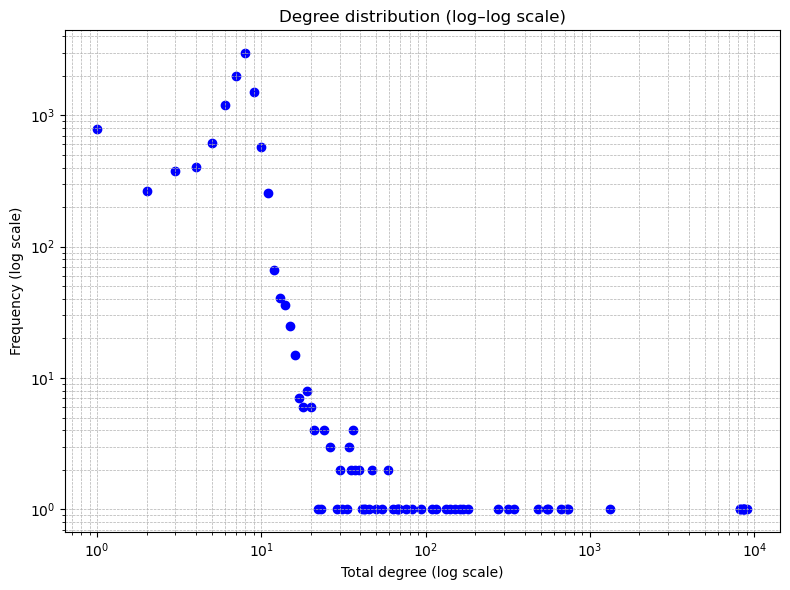

In [42]:
# --- Degree statistics (for DiGraph: use in/out/total) ---
deg_total_dict = dict(G.degree())
deg_in_dict    = dict(G.in_degree())
deg_out_dict   = dict(G.out_degree())

deg_total_vals = np.fromiter(deg_total_dict.values(), dtype=float)
deg_in_vals    = np.fromiter(deg_in_dict.values(), dtype=float)
deg_out_vals   = np.fromiter(deg_out_dict.values(), dtype=float)

def _safe_stats(arr):
    if arr.size == 0:
        return dict(mean=0.0, min=0, max=0)
    return dict(mean=arr.mean(), min=int(arr.min()), max=int(arr.max()))

stats_total = _safe_stats(deg_total_vals)
stats_in    = _safe_stats(deg_in_vals)
stats_out   = _safe_stats(deg_out_vals)

# Clustering on undirected projection
avg_clustering = nx.average_clustering(G.to_undirected())

# Edge density (for DiGraph: m / (n*(n-1)))
density = nx.density(G)

print("Graph summary:")
print(f"  Nodes: {G.number_of_nodes():,}")
print(f"  Edges: {G.number_of_edges():,}")
print(f"  Total degree — mean: {stats_total['mean']:.2f}, min: {stats_total['min']}, max: {stats_total['max']}")
print(f"  In-degree     — mean: {stats_in['mean']:.2f}, min: {stats_in['min']}, max: {stats_in['max']}")
print(f"  Out-degree    — mean: {stats_out['mean']:.2f}, min: {stats_out['min']}, max: {stats_out['max']}")
print(f"  Clustering coefficient (undirected): {avg_clustering:.4f}")
print(f"  Edge density: {density:.6f}")

# --- Degree distribution (total degree) on log–log axes ---
from collections import Counter
deg_hist = Counter(deg_total_dict.values())
deg_vals_plot, counts_plot = zip(*sorted(deg_hist.items()))

plt.figure(figsize=(8, 6))
plt.scatter(deg_vals_plot, counts_plot, marker='o', color='blue')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Total degree (log scale)')
plt.ylabel('Frequency (log scale)')
plt.title('Degree distribution (log–log scale)')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()

Top 10 highest degree nodes:
C586: 9092 connections (Red team: True)
C1065: 8638 connections (Red team: True)
C529: 8637 connections (Red team: True)
C467: 8601 connections (Red team: True)
C612: 8579 connections (Red team: True)
C528: 8475 connections (Red team: True)
C457: 8168 connections (Red team: True)
C625: 8133 connections (Red team: True)
C754: 1325 connections (Red team: True)
C92: 736 connections (Red team: True)

Highest degree node: C586 (degree=9092, Red team: True)

Super-hub computer statistics:
C586: 9092 edges, 3 destination computers, 5 events
C1065: 8638 edges, 10 destination computers, 453 events
C529: 8637 edges, 0 destination computers, 0 events
C467: 8601 edges, 0 destination computers, 0 events
C612: 8579 edges, 0 destination computers, 0 events
C528: 8475 edges, 0 destination computers, 0 events
C457: 8168 edges, 1 destination computers, 1 events
C625: 8133 edges, 0 destination computers, 0 events
C586: IN=9089, OUT=3 | As dst: 455654, As src: 5
C1065: IN=8628

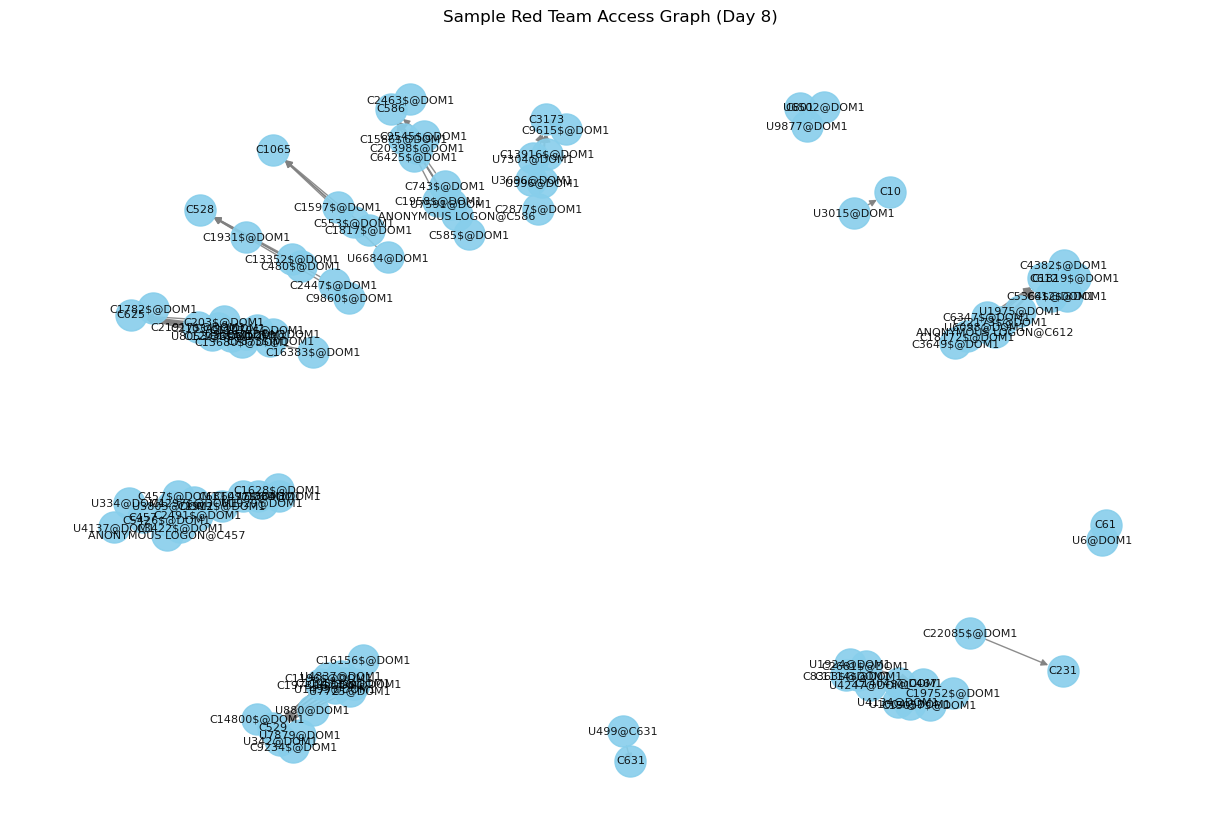

In [45]:
# --- 1. Top 10 highest-degree nodes and red team status ---
degree_series = pd.Series(dict(G.degree()), name="degree")
top_nodes = degree_series.sort_values(ascending=False).head(10)
print("Top 10 highest degree nodes:")
for node, deg in top_nodes.items():
    print(f"{node}: {deg} connections (Red team: {node in red_computers})")

# --- 2. Highest degree node check ---
max_node, max_deg = degree_series.idxmax(), degree_series.max()
print(f"\nHighest degree node: {max_node} (degree={max_deg}, Red team: {max_node in red_computers})")

# --- 3. Ensure per_computer_summary covers ALL nodes in G ---
all_computers = pd.Index(G.nodes(), name="src_computer")
per_computer_summary_full = (
    per_computer_summary.set_index("src_computer")
    .reindex(all_computers, fill_value=0)  # fill missing with zeros
    .reset_index()
)

# --- 4. Super-hub analysis from top 8 ---
print("\nSuper-hub computer statistics:")
for comp in top_nodes.head(8).index:
    row = per_computer_summary_full.loc[per_computer_summary_full["src_computer"] == comp].iloc[0]
    print(f"{comp}: {degree_series[comp]} edges, "
          f"{row['unique_dst_computers']} destination computers, "
          f"{row['total_events']} events")

# --- 5. Directional role of select nodes ---
for comp in ['C586', 'C1065', 'C457']:
    if comp in G:
        in_deg = G.in_degree(comp)
        out_deg = G.out_degree(comp)
        dst_count = (edges_df['dst_computer'] == comp).sum()
        src_count = (edges_df['src_computer'] == comp).sum()
        print(f"{comp}: IN={in_deg}, OUT={out_deg} | As dst: {dst_count}, As src: {src_count}")

# --- 6. Original attackers degree stats ---
print("\nOriginal attackers in graph analysis:")
for comp in ['C17693', 'C1823', 'C754', 'C3435']:
    if comp in G:
        print(f"{comp}: IN={G.in_degree(comp)}, OUT={G.out_degree(comp)}, TOTAL={G.degree(comp)}")

# --- 7. Sample red team success graph (Day 8 only) ---
if "day" not in auth_df.columns:
    auth_df["day"] = auth_df["time"] // 86400

red_df = auth_df[
    (auth_df["success"] == "Success") &
    (auth_df["day"] == 8) &
    (auth_df["src_computer"].isin(red_computers) | auth_df["dst_computer"].isin(red_computers))
]

red_sample = red_df.sample(n=min(100, len(red_df)), random_state=42)

G_small = nx.from_pandas_edgelist(
    red_sample,
    source="src_user",
    target="dst_computer",
    edge_attr=True,
    create_using=nx.DiGraph()
)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_small, seed=42)
nx.draw(
    G_small, pos,
    with_labels=True,
    node_size=500,
    font_size=8,
    edge_color="gray",
    node_color="skyblue",
    alpha=0.9,
    arrows=True
)
plt.title("Sample Red Team Access Graph (Day 8)")
plt.show()

### Findings from High-Degree Red Team Nodes

#### 1. **Super-hub red team computers** (e.g., `C586`, `C1065`, `C457`) show a distinctive interaction pattern:
- **Very high in-degree** (e.g., `C586`: IN = 9089)
- **Very low out-degree** (e.g., `C586`: OUT = 3)
- **Skewed source/destination behaviour**:
  - `C586`: appears **455,654 times as destination**, but only **5 times as source**
- **Low behavioural diversity despite high connectivity**:
  - `C457`: only 1 unique destination computer, 1 event, yet >8,000 edges in the graph

**Interpretation:** These machines are likely acting as red team **credential harvesting sinks** or **command-and-control (C2)** infrastructure — consistent with red team staging behaviour.

---

#### 2. **Original red team attackers** (e.g., `C17693`, `C1823`) show **classic initiator behaviour**:
- High **out-degree**, low **in-degree**
- Example:
  - `C17693`: OUT = 343, IN = 0 — acts as a pure originator
  - `C1823`: mostly OUT edges (pivoting node)

$\rightarrow$ This matches typical **attacker TTPs** (Tactics, Techniques, Procedures) in the LANL network.

---


## Step 6: Compute SVD Embeddings of the Adjacency Matrix

Adjacency matrix shape: (11218, 11218)
Sparsity of A: 99.94%
Matrix is sparse (>85%), using sparse SVD...


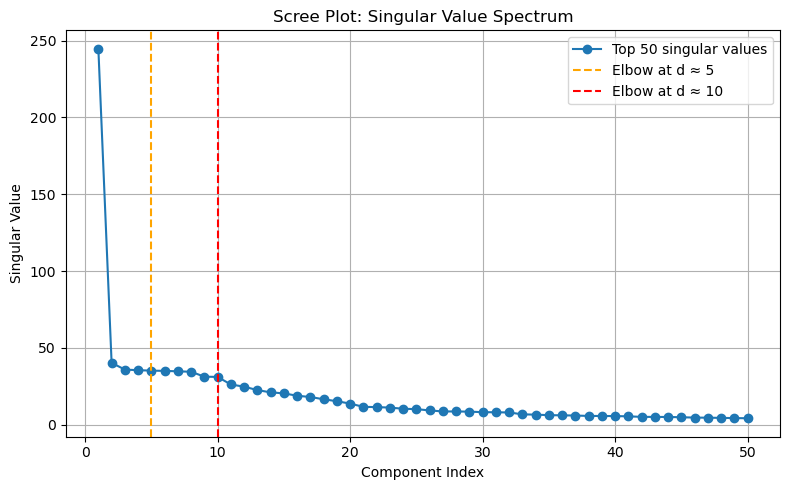

In [47]:
# --- Extract sorted list of nodes to fix row/column order ---
nodes = sorted(G.nodes())

# --- Create unweighted adjacency matrix (dense) ---
A = nx.to_numpy_array(G, nodelist=nodes, weight=None).astype(float)
print(f"Adjacency matrix shape: {A.shape}")

# --- Check sparsity ---
sparsity = np.sum(A == 0) / A.size
print(f"Sparsity of A: {sparsity:.2%}")

# --- Max dimension for SVD spectrum ---
d_max = min(50, min(A.shape) - 1)  # conservative for very large graphs

if sparsity > 0.85:
    print("Matrix is sparse (>85%), using sparse SVD...")
    A_sparse = sp.csr_matrix(A)
    U, S, VT = svds(A_sparse, k=d_max)
    U, S, VT = U[:, ::-1], S[::-1], VT[::-1, :]
else:
    print("Matrix is dense (<85% sparse), using full SVD...")
    U, S, VT = np.linalg.svd(A, full_matrices=False)
    U, S, VT = U[:, :d_max], S[:d_max], VT[:d_max, :]

# --- Scree plot + save ---
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(range(1, d_max + 1), S, marker='o', label=f"Top {d_max} singular values")
ax.axvline(5, color='orange', ls='--', label='Elbow at d ≈ 5')
ax.axvline(10, color='red', ls='--', label='Elbow at d ≈ 10')
ax.set(title="Scree Plot: Singular Value Spectrum", xlabel="Component Index", ylabel="Singular Value")
ax.grid(True); ax.legend()
fig.tight_layout()
fig.savefig("LANL_Scree.pdf", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# --- Choose embedding dimension ---
d = 5  # based on results

# --- Compute SVD-based embedding ---
X_svd = U[:, :d] @ np.diag(np.sqrt(S[:d]))

## Step 7: Clustering Evaluation & Anomaly Scoring

k=2: Silhouette Score = 0.355
k=3: Silhouette Score = 0.364
k=4: Silhouette Score = 0.386
k=5: Silhouette Score = 0.434
k=6: Silhouette Score = 0.449
k=7: Silhouette Score = 0.462
k=8: Silhouette Score = 0.501
k=9: Silhouette Score = 0.526


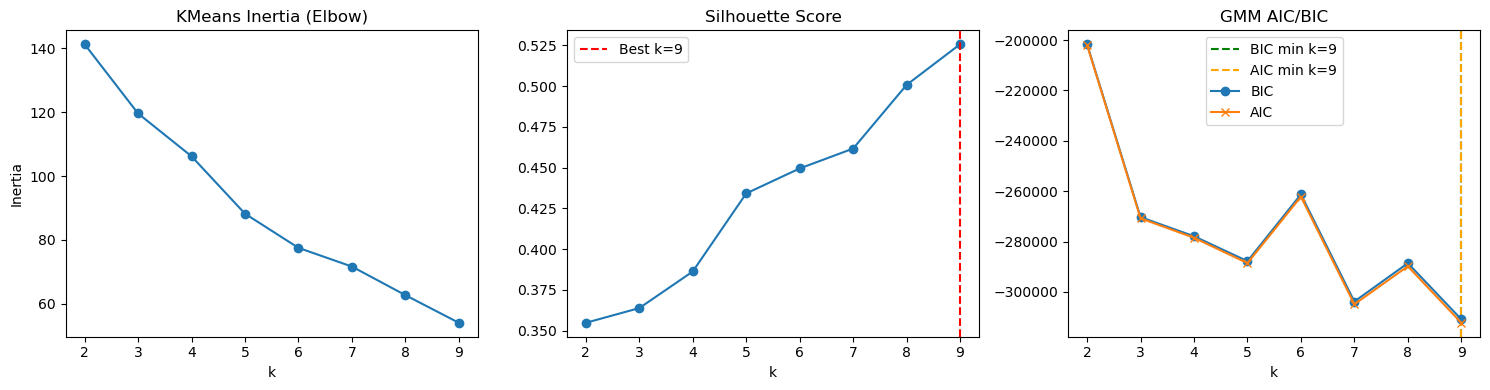

Suggested optimal k based on silhouette score: 9

Suggested optimal k based on minimum BIC: 9 (BIC=-310876.79)
Suggested optimal k based on minimum AIC: 9 (AIC=-312253.94)

X_svd mean: [ 0.1382  0.0016  0.0009 -0.0011 -0.0045]
X_svd std: [0.0521 0.0599 0.0566 0.0563 0.0559]

Sample AIC: [-201967.8578014622, -270767.6885048569, -278496.298284817, -288553.428517799, -262185.51655882504, -304889.55292752443, -289810.1433302881, -312253.9430644413]


In [48]:
# --- Determine the optimal k using SVD embedding ---

Ks = list(range(2, 10))
inertias = []
sil_scores = []
bics = []
aics = []
best_sil_score = -1
best_k_sil = None

for k in Ks:
    km = KMeans(n_clusters=k, random_state=42).fit(X_svd)
    inertias.append(km.inertia_)
    sil = silhouette_score(X_svd, km.labels_)
    sil_scores.append(sil)
    if sil > best_sil_score:
        best_sil_score = sil
        best_k_sil = k
    print(f"k={k}: Silhouette Score = {sil:.3f}")
    
    gm = GaussianMixture(n_components=k, random_state=42).fit(X_svd)
    bics.append(gm.bic(X_svd))
    aics.append(gm.aic(X_svd))

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(Ks, inertias, marker='o')
plt.title("KMeans Inertia (Elbow)")
plt.xlabel("k")
plt.ylabel("Inertia")

plt.subplot(1, 3, 2)
plt.plot(Ks, sil_scores, marker='o')
plt.title("Silhouette Score")
plt.xlabel("k")
plt.axvline(x=best_k_sil, linestyle='--', color='red', label=f'Best k={best_k_sil}')
plt.legend()

plt.subplot(1, 3, 3)
min_bic = min(bics)
min_bic_k = Ks[bics.index(min_bic)]
min_aic = min(aics)
min_aic_k = Ks[aics.index(min_aic)]

plt.axvline(x=min_bic_k, linestyle='--', color='green', label=f'BIC min k={min_bic_k}')
plt.axvline(x=min_aic_k, linestyle='--', color='orange', label=f'AIC min k={min_aic_k}')
plt.plot(Ks, bics, label="BIC", marker='o')
plt.plot(Ks, aics, label="AIC", marker='x')
plt.title("GMM AIC/BIC")
plt.xlabel("k")
plt.legend()

plt.tight_layout()
plt.savefig("k_selection_LANL.pdf", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"Suggested optimal k based on silhouette score: {best_k_sil}")
print(f"\nSuggested optimal k based on minimum BIC: {min_bic_k} (BIC={min_bic:.2f})")
print(f"Suggested optimal k based on minimum AIC: {min_aic_k} (AIC={min_aic:.2f})")
print("\nX_svd mean:", X_svd.mean(axis=0).round(4))
print("X_svd std:", X_svd.std(axis=0).round(4))
print("\nSample AIC:", aics)

### Clustering Selection via SVD Embedding

To determine the optimal number of clusters $ k $ in the LANL authentication network, we applied both **KMeans** and **Gaussian Mixture Models (GMM)** to the SVD-based latent space $ X_{svd} \in \mathbb{R}^{n \times d}$, where $d = 5$ was chosen based on the scree plot.

We evaluated each model using:
- **KMeans**: Inertia and Silhouette Score.
- **GMM**: Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC).

The results indicate:
- **Best Silhouette Score** at $ k = 9 $:  
  $$
  \max \text{ Silhouette}(k) = 0.526 \quad \text{at } k = 9
  $$
- **Minimum BIC and AIC** also occur at $ k = 9 $:  
  $$
  \min \text{ BIC}(k) = -310{,}876.79, \quad \min \text{ AIC}(k) = -312{,}253.94
  $$

This alignment across **three independent criteria** supports the choice of $ k=9 $ for downstream anomaly detection and community analysis.

---

KMeans Silhouette Score for k=9: 0.526

GMM Silhouette Score for k=9: 0.423


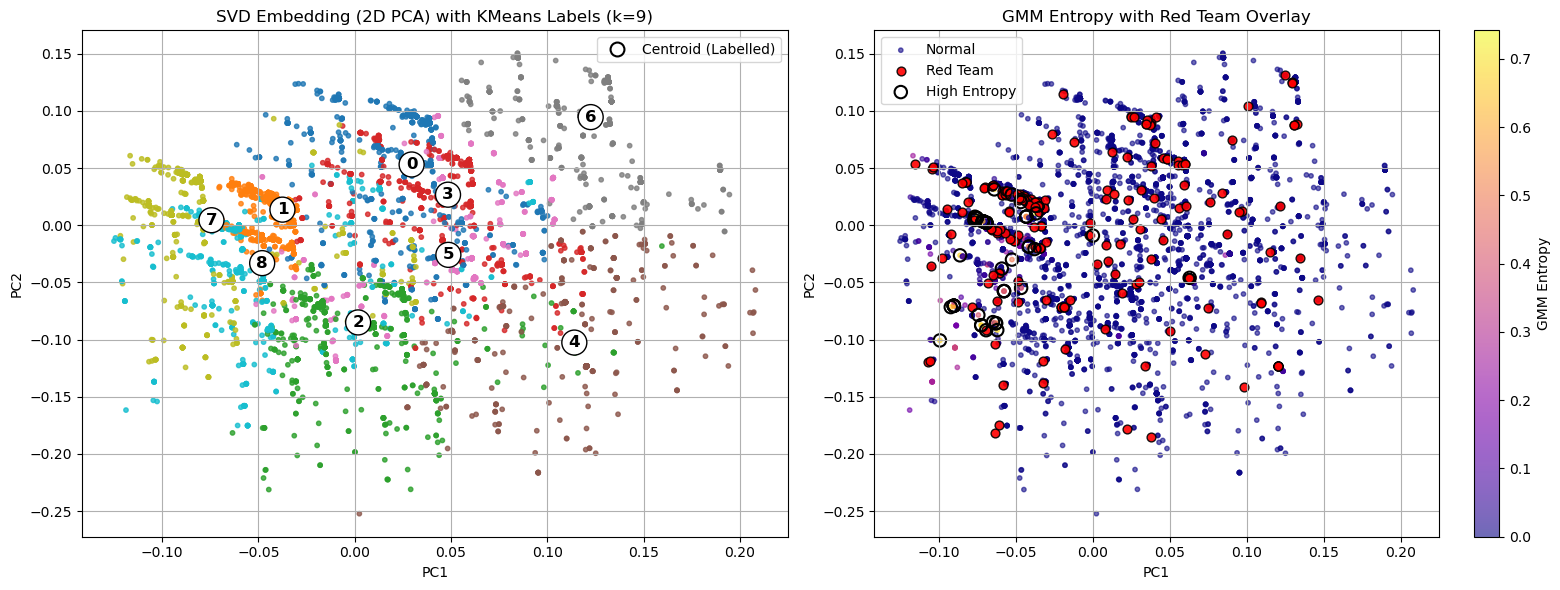

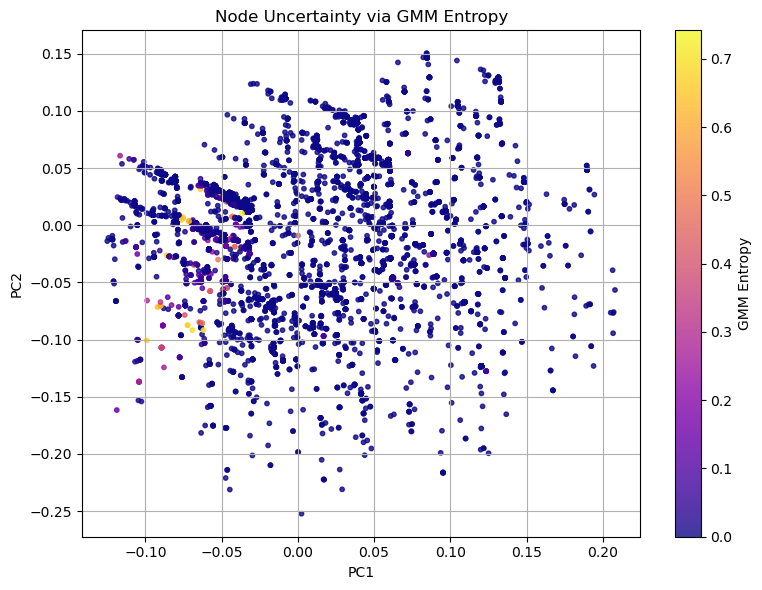

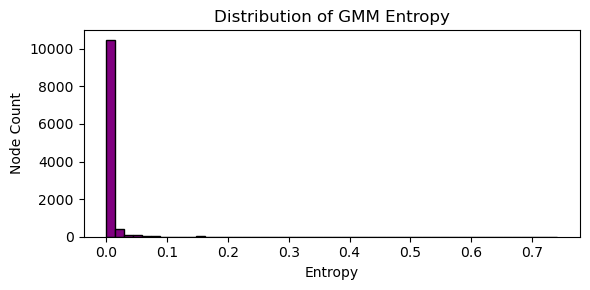

Red Team by Cluster


,Cluster,Red Team Count,Cluster Size,Red %
0,0,26,1008,2.6%
1,1,104,4479,2.3%
2,2,15,1025,1.5%
3,3,21,976,2.2%
4,4,14,625,2.2%
5,5,74,844,8.8%
6,6,9,619,1.5%
7,7,19,759,2.5%
8,8,22,883,2.5%



Entropy range: -0.0000 to 0.7418


In [52]:
# --- Parameters ---
k = 9
topk = 50  # Highlight top-k entropy nodes

# --- PCA projection for plotting ---
pca = PCA(n_components=2, svd_solver='full', random_state=42)
X_2d = pca.fit_transform(X_svd)

# --- KMeans clustering ---
kmeans_svd = KMeans(n_clusters=k, random_state=42).fit(X_svd)
kmeans_labels_svd = kmeans_svd.labels_
sil_score_kmeans = silhouette_score(X_svd, kmeans_labels_svd)
kmeans_centres_2d = pca.transform(kmeans_svd.cluster_centers_)

print(f"KMeans Silhouette Score for k={k}: {sil_score_kmeans:.3f}")
unique_kmeans, counts_kmeans = np.unique(kmeans_labels_svd, return_counts=True)

# --- GMM clustering ---
gmm_svd = GaussianMixture(n_components=k, random_state=42).fit(X_svd)
gmm_labels_svd = gmm_svd.predict(X_svd)
sil_score_gmm = silhouette_score(X_svd, gmm_labels_svd)

print(f"\nGMM Silhouette Score for k={k}: {sil_score_gmm:.3f}")
unique_gmm, counts_gmm = np.unique(gmm_labels_svd, return_counts=True)

# --- GMM entropy ---
gmm_probs = gmm_svd.predict_proba(X_svd)
entropy_scores = -np.sum(gmm_probs * np.log(gmm_probs + 1e-12), axis=1)
top_entropy_idx = np.argsort(entropy_scores)[-topk:]

# --- Red team mask ---
node_to_index = {node: i for i, node in enumerate(nodes)}
red_mask = np.array([node in red_computers for node in nodes])

# --- Side-by-side plots ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# -- Plot 1: KMeans Clusters --
scatter1 = axes[0].scatter(
    X_2d[:, 0], X_2d[:, 1],
    c=kmeans_labels_svd, cmap="tab10", s=10, alpha=0.8
)

# Add numbered cluster centroids
for i, (x, y) in enumerate(kmeans_centres_2d):
    axes[0].text(x, y, str(i), fontsize=12, weight='bold', ha='center', va='center',
                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='circle'))
axes[0].set_title(f"SVD Embedding (2D PCA) with KMeans Labels (k={k})")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
axes[0].grid(True)

# Dummy for legend
centroid_legend = Line2D([0], [0], marker='o', color='w',
                         label='Centroid (Labelled)',
                         markerfacecolor='white', markeredgecolor='black',
                         markersize=10, markeredgewidth=1.5)
axes[0].legend(handles=[centroid_legend])

# -- Plot 2: GMM Entropy with Red Overlay --
scatter2 = axes[1].scatter(
    X_2d[~red_mask, 0], X_2d[~red_mask, 1],
    c=entropy_scores[~red_mask], cmap="plasma", s=10, alpha=0.6, label="Normal"
)
axes[1].scatter(
    X_2d[red_mask, 0], X_2d[red_mask, 1],
    c='red', edgecolor='black', s=40, label="Red Team", alpha=0.9
)
# Highlight top entropy nodes
axes[1].scatter(
    X_2d[top_entropy_idx, 0], X_2d[top_entropy_idx, 1],
    facecolors='none', edgecolors='black', s=80, linewidths=1.5, label='High Entropy'
)

cbar = fig.colorbar(scatter2, ax=axes[1])
cbar.set_label("GMM Entropy")
axes[1].set_title("GMM Entropy with Red Team Overlay")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
fig.savefig("Fig_Clustering_and_Entropy.pdf", format='pdf', bbox_inches='tight')
plt.show()

# --- Full GMM Entropy Heatmap (standalone) ---
plt.figure(figsize=(8, 6))
plt.scatter(
    X_2d[:, 0], X_2d[:, 1],
    c=entropy_scores, cmap="plasma", s=10, alpha=0.8
)
plt.colorbar(label="GMM Entropy")
plt.title("Node Uncertainty via GMM Entropy")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Entropy histogram ---
plt.figure(figsize=(6, 3))
plt.hist(entropy_scores, bins=50, color='purple', edgecolor='black')
plt.title("Distribution of GMM Entropy")
plt.xlabel("Entropy")
plt.ylabel("Node Count")
plt.tight_layout()
plt.show()

# --- Red team by cluster summary ---
cluster_ids = []
red_counts = []
cluster_sizes = []
red_percents = []

for cluster_id in range(k):
    cluster_mask = kmeans_labels_svd == cluster_id
    cluster_nodes = np.array(nodes)[cluster_mask]
    red_in_cluster = sum(1 for node in cluster_nodes if node in red_computers)
    total_in_cluster = len(cluster_nodes)
    cluster_ids.append(cluster_id)
    red_counts.append(red_in_cluster)
    cluster_sizes.append(total_in_cluster)
    red_percents.append(f"{100 * red_in_cluster / total_in_cluster:.1f}%")

# Create summary table
summary_df = pd.DataFrame({
    "Cluster": cluster_ids,
    "Red Team Count": red_counts,
    "Cluster Size": cluster_sizes,
    "Red %": red_percents
})

print("Red Team by Cluster")
                                                           
display(summary_df)

# --- Entropy range summary ---
print(f"\nEntropy range: {entropy_scores.min():.4f} to {entropy_scores.max():.4f}")

## Step 8: Clustering Evaluation & Anomaly Scoring

### AnomalyDetector Class Summary

A modular class for anomaly detection and evaluation using multiple scoring strategies (KMeans, GMM, and Entropy). It includes score computation, red team labelling, statistical comparison, and plotting utilities.

---

#### `__init__(...)`
Initialises the detector with evaluation parameters:
- `top_ks`: list of cutoffs for top-k evaluation (e.g., 10, 50, 100).
- `threshold_percentile`: score percentile to evaluate high-score anomalies (e.g., 95%).

---

#### `create_anomaly_dataframe(...)`
Generates a DataFrame with per-node anomaly scores:
- Computes:
  - KMeans distance to closest centroid
  - GMM negative log-likelihood
  - Entropy (from GMM soft cluster assignments)
- Flags red team nodes and assigns cluster labels.
- Adds a `combined_score` as the average rank across all three metrics.

---

#### `evaluate_scores_batch(...)`
Evaluates multiple scoring columns (e.g., KMeans, GMM, Entropy):
- Computes:
  - Precision and Recall at `top_k` cutoffs
  - Precision/Recall at specified percentile threshold
  - ROC AUC
- Returns a nested dictionary of results per score column.

---

#### `get_group_stats(...)`
Returns cached or fresh group-wise statistics:
- Splits nodes into red team vs. non-red.
- Caches grouped subsets and counts for downstream use.

---

#### `print_summary_statistics(...)`
Prints a summary of score distributions:
- Displays `.describe()` stats for full DataFrame.
- Shows detailed stats (min/mean/median/max/count) for each method split by group.

---

#### `create_evaluation_plots(...)`
Generates side-by-side KDE plots for KMeans and GMM scores:
- Shows red vs. non-red distributions.
- Annotates plots with performance metrics and group statistics.
- Returns evaluation dictionaries for KMeans and GMM.

---

#### `_create_single_plot(...)`
Helper method used internally to render an annotated plot for a single score:
- Includes shaded KDEs, dashed red mean line, and overlaid performance/stat boxes.

---

#### `create_entropy_kde_plot(...)`
Generates a KDE plot for entropy scores:
- Highlights red vs. non-red groups.
- Uses an inset axis to visualise full score range.
- Annotates performance and statistical summary boxes.

---

#### `_add_entropy_text_boxes(...)`
Helper for `create_entropy_kde_plot(...)`:
- Adds consistent performance and group statistic overlays to the plot.

---

#### `run_complete_analysis(...)`
Runs the full pipeline:
- Computes all scores and flags
- Displays summary statistics
- Generates evaluation plots for KMeans and GMM
- Returns the full anomaly DataFrame and result dictionaries.

---

#### `print_entropy_stats_table(...)`
Prints a detailed entropy statistics table:
- Displays red vs. non-red `.describe()` summary in a structured table format.

---

In [53]:
class AnomalyDetector:
    """ Optimised anomaly detection analysis with caching and vectorised operations."""
    
    def __init__(self, top_ks: List[int] = [10, 50, 100], threshold_percentile: float = 0.95):
        self.top_ks = top_ks
        self.threshold_percentile = threshold_percentile
        self._cached_stats = {}
        
    def create_anomaly_dataframe(self, X_svd: np.ndarray, nodes: List[str], 
                               kmeans_svd, gmm_svd, df_red: pd.DataFrame) -> pd.DataFrame:
        """Create comprehensive anomaly score DataFrame with vectorised operations."""
        
        # Pre-compute red team nodes set for O(1) lookup
        red_nodes = set(df_red["src_computer"]).union(df_red["dst_computer"])
        
        # Vectorised operations
        kmeans_distances = pairwise_distances(X_svd, kmeans_svd.cluster_centers_).min(axis=1)
        gmm_scores = -gmm_svd.score_samples(X_svd)
        
        # Vectorised entropy calculation with numerical stability
        probs = gmm_svd.predict_proba(X_svd)
        entropy_scores = -np.sum(probs * np.log(np.maximum(probs, 1e-10)), axis=1)
        
        # Vectorised red team flags
        red_flags = np.array([node in red_nodes for node in nodes], dtype=int)
        
        # Create DataFrame with all computed values
        anomaly_df = pd.DataFrame({
            'node': nodes,
            'kmeans_score_svd': kmeans_distances,
            'gmm_score_svd': gmm_scores,
            'entropy_score': entropy_scores,
            'kmeans_label': kmeans_svd.labels_,
            'gmm_label': gmm_svd.predict(X_svd),
            'is_redteam': red_flags
        })

        # Vectorised combined score calculation
        score_cols = ['kmeans_score_svd', 'gmm_score_svd', 'entropy_score']
        ranks = anomaly_df[score_cols].rank(method="average", ascending=True)
        anomaly_df["combined_score"] = ranks.mean(axis=1)

        return anomaly_df

    def evaluate_scores_batch(self, anomaly_df: pd.DataFrame, 
                            score_cols: List[str]) -> Dict[str, Dict]:
        """Batch evaluation of multiple score columns for efficiency."""
        all_results = {}
        
        for score_col in score_cols:
            results = {}
            df_sorted = anomaly_df.sort_values(by=score_col, ascending=False)
            
            # Vectorised top-k calculations
            total_positives = anomaly_df['is_redteam'].sum()
            
            for k in self.top_ks:
                if k <= len(df_sorted):
                    topk_positives = df_sorted['is_redteam'].iloc[:k].sum()
                    results[f'Precision@{k}'] = topk_positives / k
                    results[f'Recall@{k}'] = topk_positives / total_positives if total_positives > 0 else 0
            
            # Threshold-based metrics
            threshold = anomaly_df[score_col].quantile(self.threshold_percentile)
            above_threshold = anomaly_df[anomaly_df[score_col] >= threshold]
            
            if len(above_threshold) > 0:
                results['Precision@95%ile'] = above_threshold['is_redteam'].mean()
                results['Recall@95%ile'] = above_threshold['is_redteam'].sum() / total_positives if total_positives > 0 else 0
            else:
                results['Precision@95%ile'] = 0
                results['Recall@95%ile'] = 0
            
            # ROC AUC
            results['ROC AUC'] = roc_auc_score(anomaly_df['is_redteam'], anomaly_df[score_col])
            
            all_results[score_col] = results
            
        return all_results

    def get_group_stats(self, anomaly_df: pd.DataFrame, cache_key: str = None) -> Dict:
        """Get cached group statistics to avoid recomputation."""
        if cache_key and cache_key in self._cached_stats:
            return self._cached_stats[cache_key]
            
        red_team_data = anomaly_df[anomaly_df['is_redteam'] == 1]
        non_red_data = anomaly_df[anomaly_df['is_redteam'] == 0]
        
        stats = {
            'red_team': red_team_data,
            'non_red': non_red_data,
            'red_count': len(red_team_data),
            'non_red_count': len(non_red_data)
        }
        
        if cache_key:
            self._cached_stats[cache_key] = stats
            
        return stats

    def print_summary_statistics(self, anomaly_df: pd.DataFrame):
        """ Optimised summary statistics with reduced redundancy."""
        print("=== ANOMALY DETECTION SUMMARY ===")
        display(anomaly_df.describe())
        
        group_stats = self.get_group_stats(anomaly_df, 'main_stats')
        print(f"\nRed team nodes found: {group_stats['red_count']} / {len(anomaly_df)} nodes")
        
        # Vectorised statistics calculation
        metrics = ["kmeans_score_svd", "gmm_score_svd", "entropy_score"]
        metric_names = ["KMeans", "GMM", "Entropy"]
        
        stats_data = []
        for metric, name in zip(metrics, metric_names):
            for group_name, group_data in [('Red Team', group_stats['red_team']), 
                                         ('Non-Red Team', group_stats['non_red'])]:
                if len(group_data) > 0:
                    desc = group_data[metric].describe()
                    stats_data.append({
                        'Method': name,
                        'Group': group_name,
                        'Min': desc['min'],
                        'Mean': desc['mean'],
                        'Median': desc['50%'],
                        'Max': desc['max'],
                        'Count': desc['count']
                    })
        
        stats_df = pd.DataFrame(stats_data)
        print("\n=== DETAILED STATISTICS BY GROUP ===")
        display(stats_df.round(4))

    def create_evaluation_plots(self, anomaly_df: pd.DataFrame) -> Tuple[Dict, Dict]:
        """ Optimised plotting with shared calculations."""
        group_stats = self.get_group_stats(anomaly_df, 'plot_stats')
        
        # Batch evaluate scores
        score_results = self.evaluate_scores_batch(anomaly_df, ['kmeans_score_svd', 'gmm_score_svd'])
        results_kmeans = score_results['kmeans_score_svd']
        results_gmm = score_results['gmm_score_svd']
        
        # Pre-calculate means
        red_means = {
            'kmeans': group_stats['red_team']["kmeans_score_svd"].mean(),
            'gmm': group_stats['red_team']["gmm_score_svd"].mean()
        }
        
        # Create plots with shared styling function
        fig, axs = plt.subplots(1, 2, figsize=(16, 6))
        
        plot_configs = [
            {
                'ax': axs[0], 
                'score_col': 'kmeans_score_svd',
                'title': 'KMeans Distance-Based Anomaly Scores',
                'xlabel': 'Distance to Centroid',
                'mean_val': red_means['kmeans'],
                'results': results_kmeans,
                'box_color': 'lightblue'
            },
            {
                'ax': axs[1],
                'score_col': 'gmm_score_svd', 
                'title': 'GMM Negative Log-Likelihood Anomaly Scores',
                'xlabel': 'Anomaly Score (-Log Likelihood)',
                'mean_val': red_means['gmm'],
                'results': results_gmm,
                'box_color': 'lightgreen'
            }
        ]
        
        for config in plot_configs:
            self._create_single_plot(anomaly_df, group_stats, config)
        
        plt.tight_layout()
        plt.show()
        
        return results_kmeans, results_gmm

    def _create_single_plot(self, anomaly_df: pd.DataFrame, group_stats: Dict, config: Dict):
        """Helper method to create individual plots with consistent styling."""
        ax = config['ax']
        score_col = config['score_col']
        
        # Plot KDE
        sns.kdeplot(data=group_stats['non_red'], x=score_col,
                   label="Non-Red Team", fill=True, alpha=0.4, ax=ax)
        sns.kdeplot(data=group_stats['red_team'], x=score_col,
                   label="Red Team", fill=True, color="red", alpha=0.5, ax=ax)
        ax.axvline(config['mean_val'], color="red", linestyle="--", label="Red Team Mean")
        
        ax.set_title(config['title'])
        ax.set_xlabel(config['xlabel'])
        ax.legend()
        
        # Add performance metrics
        results = config['results']
        perf_text = (
            f"PERFORMANCE METRICS\n"
            f"Precision@10: {results['Precision@10']:.2f}\n"
            f"Recall@10:    {results['Recall@10']:.4f}\n"
            f"Precision@95%: {results['Precision@95%ile']:.3f}\n"
            f"Recall@95%:    {results['Recall@95%ile']:.3f}\n"
            f"ROC AUC:      {results['ROC AUC']:.2f}"
        )
        ax.text(0.98, 0.98, perf_text, transform=ax.transAxes,
               fontsize=9, verticalalignment='top', horizontalalignment='right',
               bbox=dict(boxstyle="round,pad=0.4", facecolor='white', alpha=0.9),
               fontfamily='monospace')
        
        # Add statistics box
        red_stats = group_stats['red_team'][score_col].describe()
        nonred_stats = group_stats['non_red'][score_col].describe()
        
        stats_text = (
            f"STATISTICS COMPARISON\n"
            f"{'':>8} {'Red':>8} {'Non-Red':>8}\n"
            f"{'Min:':>8} {red_stats['min']:>8.3f} {nonred_stats['min']:>8.3f}\n"
            f"{'Mean:':>8} {red_stats['mean']:>8.3f} {nonred_stats['mean']:>8.3f}\n"
            f"{'Median:':>8} {red_stats['50%']:>8.3f} {nonred_stats['50%']:>8.3f}\n"
            f"{'Max:':>8} {red_stats['max']:>8.3f} {nonred_stats['max']:>8.3f}\n"
            f"{'Count:':>8} {int(red_stats['count']):>8} {int(nonred_stats['count']):>8}"
        )
        ax.text(0.73, 0.75, stats_text, transform=ax.transAxes,
               fontsize=8, verticalalignment='top', horizontalalignment='left',
               bbox=dict(boxstyle="round,pad=0.4", facecolor=config['box_color'], alpha=0.8),
               fontfamily='monospace')

    def create_entropy_kde_plot(self, anomaly_df: pd.DataFrame) -> Dict:
        """ Optimised entropy plotting with cached statistics."""
        group_stats = self.get_group_stats(anomaly_df, 'entropy_stats')
        
        # Evaluate performance
        entropy_results = self.evaluate_scores_batch(anomaly_df, ['entropy_score'])['entropy_score']
        
        # Get cached statistics
        red_stats = group_stats['red_team']['entropy_score'].describe()
        nonred_stats = group_stats['non_red']['entropy_score'].describe()

        # Create optimised plot
        fig, ax = plt.subplots(figsize=(8, 5))
        
        # Use pre-filtered data
        sns.kdeplot(group_stats['non_red']['entropy_score'], label='Non-Red Team',
                   fill=True, alpha=0.4, ax=ax)
        sns.kdeplot(group_stats['red_team']['entropy_score'], label='Red Team',
                   fill=True, color='red', alpha=0.5, ax=ax)

        ax.axvline(red_stats['mean'], color="red", linestyle="--", label="Red Team Mean")
        
        # Optimised xlim calculation
        xlim_max = anomaly_df['entropy_score'].quantile(0.99)
        ax.set_xlim(0, xlim_max)
        ax.set_title("Entropy-Based Anomaly Scores")
        ax.set_xlabel("Entropy Score")
        ax.set_ylabel("Density")
        ax.legend()

        # Inset plot
        axins = inset_axes(ax, width="30%", height="30%", loc='center')
        sns.kdeplot(group_stats['non_red']['entropy_score'], fill=True, alpha=0.3, ax=axins)
        sns.kdeplot(group_stats['red_team']['entropy_score'], fill=True, color='red', alpha=0.3, ax=axins)
        axins.set_xlim(0, anomaly_df['entropy_score'].max() * 1.05)
        axins.set_title("Full Range", fontsize=10)
        axins.tick_params(labelsize=6)

        # Add text boxes (reusing format from previous method)
        self._add_entropy_text_boxes(ax, entropy_results, red_stats, nonred_stats)
        
        plt.show()
        return entropy_results

    def _add_entropy_text_boxes(self, ax, results: Dict, red_stats, nonred_stats):
        """Helper method to add text boxes to entropy plot."""
        # Performance metrics box
        perf_text = (
            f"PERFORMANCE METRICS\n"
            f"Precision@10:   {results['Precision@10']:.2f}\n"
            f"Recall@10:      {results['Recall@10']:.4f}\n"
            f"Precision@95%:  {results['Precision@95%ile']:.3f}\n"
            f"Recall@95%:     {results['Recall@95%ile']:.3f}\n"
            f"ROC AUC:        {results['ROC AUC']:.3f}"
        )
        ax.text(0.98, 0.96, perf_text, transform=ax.transAxes,
               fontsize=9, verticalalignment='top', horizontalalignment='right',
               bbox=dict(boxstyle="round,pad=0.4", facecolor='white', alpha=0.9),
               fontfamily='monospace')

        # Statistics box
        stats_text = (
            f"STATISTICS COMPARISON\n"
            f"{'':>8} {'Red':>8} {'Non-Red':>8}\n"
            f"{'Min:':>8} {red_stats['min']:>8.3f} {nonred_stats['min']:>8.3f}\n"
            f"{'Mean:':>8} {red_stats['mean']:>8.3f} {nonred_stats['mean']:>8.3f}\n"
            f"{'Median:':>8} {red_stats['50%']:>8.3f} {nonred_stats['50%']:>8.3f}\n"
            f"{'Max:':>8} {red_stats['max']:>8.3f} {nonred_stats['max']:>8.3f}\n"
            f"{'Count:':>8} {int(red_stats['count']):>8} {int(nonred_stats['count']):>8}"
        )
        ax.text(0.70, 0.68, stats_text, transform=ax.transAxes,
               fontsize=8, verticalalignment='top', horizontalalignment='left',
               bbox=dict(boxstyle="round,pad=0.4", facecolor='lightyellow', alpha=0.8),
               fontfamily='monospace')

    def run_complete_analysis(self, X_svd: np.ndarray, nodes: List[str], 
                            kmeans_svd, gmm_svd, df_red: pd.DataFrame) -> Tuple[pd.DataFrame, Dict, Dict]:
        """ Optimised complete analysis pipeline."""
        # Create anomaly DataFrame
        anomaly_df = self.create_anomaly_dataframe(X_svd, nodes, kmeans_svd, gmm_svd, df_red)
        
        # Print summary statistics
        self.print_summary_statistics(anomaly_df)
        
        # Create evaluation plots and get results
        results_kmeans, results_gmm = self.create_evaluation_plots(anomaly_df)
        
        return anomaly_df, results_kmeans, results_gmm

    def print_entropy_stats_table(self, anomaly_df: pd.DataFrame):
        """ Optimised entropy statistics table using cached data."""
        group_stats = self.get_group_stats(anomaly_df, 'entropy_table_stats')
        
        stats_data = []
        
        # Use cached group data
        for group_name, group_data in [('Red Team', group_stats['red_team']), 
                                     ('Non-Red Team', group_stats['non_red'])]:
            if len(group_data) > 0:
                desc = group_data["entropy_score"].describe()
                stats_data.append({
                    'Method': 'Entropy',
                    'Group': group_name,
                    'Min': desc['min'],
                    'Mean': desc['mean'], 
                    'Median': desc['50%'],
                    'Max': desc['max'],
                    'Count': desc['count']
                })

        stats_df = pd.DataFrame(stats_data)


=== ANOMALY DETECTION SUMMARY ===


,kmeans_score_svd,gmm_score_svd,entropy_score,kmeans_label,gmm_label,is_redteam,combined_score
count,11218.000000,11218.000000,1.121800e+04,11218.000000,11218.000000,11218.000000,11218.000000
mean,0.052939,-13.934299,6.847154e-03,2.876449,2.942860,0.027099,5609.500000
std,0.044895,5.868825,4.381183e-02,2.527071,2.603212,0.162380,1796.435132
min,0.006789,-22.316804,6.914318e-64,0.000000,0.000000,0.000000,2080.166667
25%,0.011907,-21.204420,2.620438e-37,1.000000,1.000000,0.000000,4019.708333
50%,0.038731,-12.519485,1.418264e-04,2.000000,2.000000,0.000000,5571.333333
75%,0.082668,-9.227267,3.951411e-04,5.000000,5.000000,0.000000,7056.000000
max,0.222756,32.025138,7.417663e-01,8.000000,8.000000,1.000000,11173.333333



Red team nodes found: 304 / 11218 nodes

=== DETAILED STATISTICS BY GROUP ===


,Method,Group,Min,Mean,Median,Max,Count
0,KMeans,Red Team,0.0068,0.0484,0.0346,0.2079,304.0
1,KMeans,Non-Red Team,0.0069,0.0531,0.0389,0.2228,10914.0
2,GMM,Red Team,-22.3168,-13.2635,-14.4328,32.0251,304.0
3,GMM,Non-Red Team,-22.3138,-13.9530,-12.5087,0.7211,10914.0
4,Entropy,Red Team,0.0000,0.0163,0.0003,0.6903,304.0
5,Entropy,Non-Red Team,0.0000,0.0066,0.0001,0.7418,10914.0


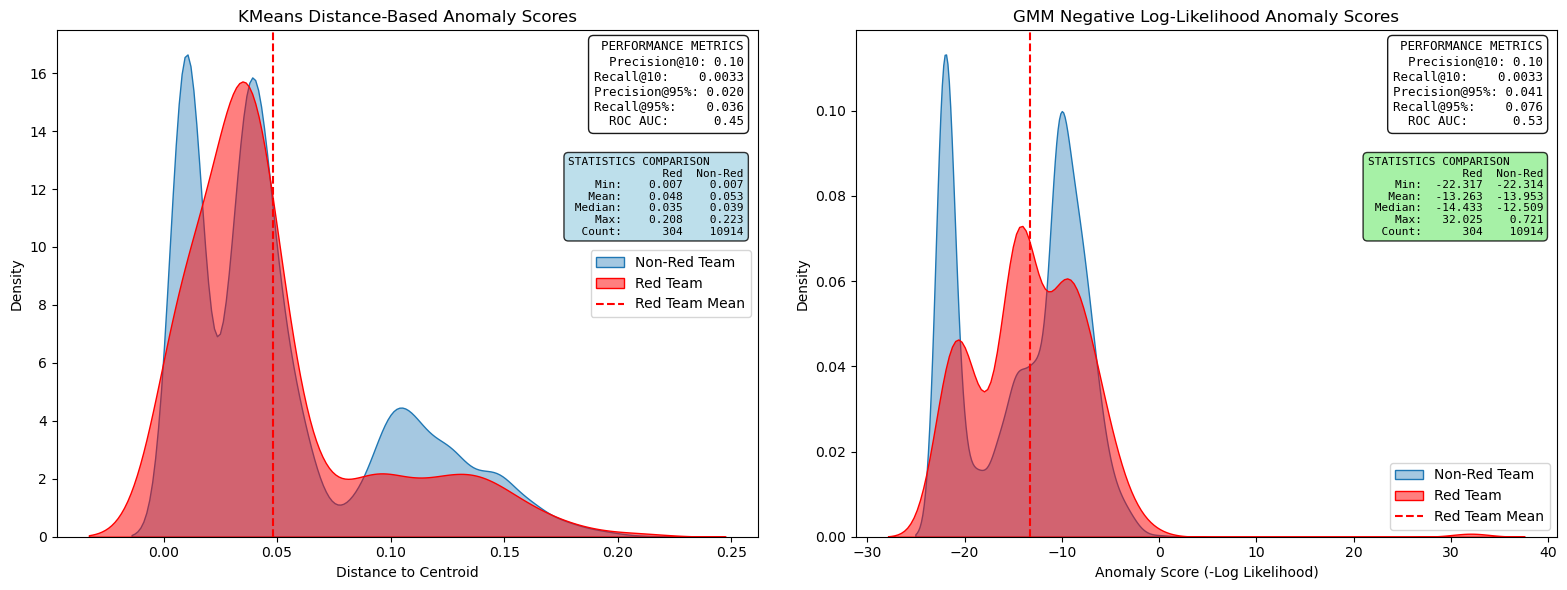

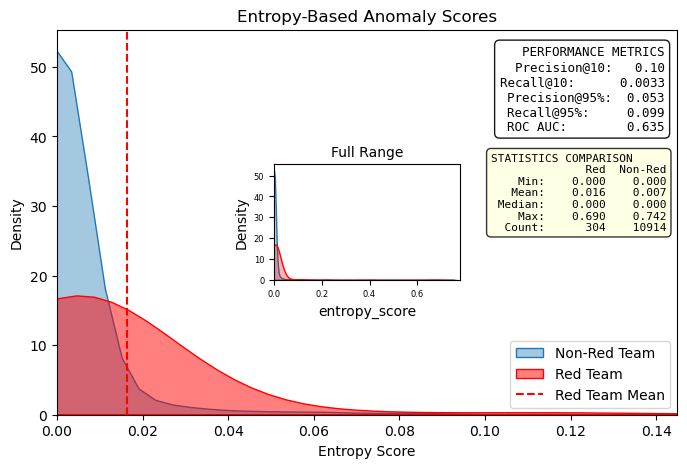


=== COMPREHENSIVE PERFORMANCE COMPARISON (ALL METHODS) ===


,Precision@10,Recall@10,Precision@50,Recall@50,Precision@100,Recall@100,Precision@95%ile,Recall@95%ile,ROC AUC
KMeans,0.1,0.003289,0.02,0.003289,0.03,0.009868,0.019608,0.036184,0.450517
GMM,0.1,0.003289,0.06,0.009868,0.03,0.009868,0.040998,0.075658,0.530507
Entropy,0.1,0.003289,0.06,0.009868,0.05,0.016447,0.053476,0.098684,0.634718


In [54]:
# Implement
def optimised_workflow(X_svd, nodes, kmeans_svd, gmm_svd, df_red):
    """ Optimised workflow combining all analysis steps."""
    detector = AnomalyDetector()
    
    # Run complete analysis
    anomaly_df, kmeans_results, gmm_results = detector.run_complete_analysis(
        X_svd, nodes, kmeans_svd, gmm_svd, df_red
    )
    
    # Entropy analysis (reuses cached statistics)
    detector.print_entropy_stats_table(anomaly_df)
    results_entropy = detector.create_entropy_kde_plot(anomaly_df)
        
    return anomaly_df, kmeans_results, gmm_results, results_entropy

# Create detector instance
detector = AnomalyDetector()

# Run optimised workflow
anomaly_df, kmeans_results, gmm_results, entropy_results = optimised_workflow(
    X_svd, nodes, kmeans_svd, gmm_svd, df_red
)

# Combined output
print("\n" + "="*85)
print("=== COMPREHENSIVE PERFORMANCE COMPARISON (ALL METHODS) ===")  
print("="*85)

combined_results_table = pd.DataFrame([
    kmeans_results, 
    gmm_results, 
    entropy_results
], index=['KMeans', 'GMM', 'Entropy'])

display(combined_results_table.round(6))

In [55]:
# Top anomalies
print("\n=== TOP 20 ANOMALIES ===")
top_anomalies = anomaly_df.sort_values("combined_score", ascending=False).head(20)
display(top_anomalies)
    
# Suspicious non-red team nodes
suspicious_nonred = top_anomalies[top_anomalies["is_redteam"] == 0]
print(f"\nSuspicious Non-Red Team Nodes (Potential FN): {len(suspicious_nonred)}")
if len(suspicious_nonred) > 0:
    display(suspicious_nonred)


=== TOP 20 ANOMALIES ===


,node,kmeans_score_svd,gmm_score_svd,entropy_score,kmeans_label,gmm_label,is_redteam,combined_score
8630,C5400,0.203486,-2.023647,0.157164,8,7,0,11173.333333
8189,C4509,0.163486,-5.351281,0.269649,8,7,0,11016.000000
3288,C15805,0.163486,-5.351281,0.269649,8,7,0,11016.000000
6288,C21934,0.163486,-5.351281,0.269649,8,7,0,11016.000000
3751,C16717,0.163486,-5.351281,0.269649,8,7,0,11016.000000
7860,C3873,0.163486,-5.351281,0.269649,8,7,0,11016.000000
4514,C18312,0.163486,-5.351281,0.269649,8,7,0,11016.000000
2011,C13459,0.163486,-5.351281,0.269649,8,7,0,11016.000000
6441,C22222,0.157177,-4.788965,0.272664,7,7,0,11015.333333
7920,C3988,0.192402,-5.024759,0.014646,8,7,0,10862.666667



Suspicious Non-Red Team Nodes (Potential FN): 19


,node,kmeans_score_svd,gmm_score_svd,entropy_score,kmeans_label,gmm_label,is_redteam,combined_score
8630,C5400,0.203486,-2.023647,0.157164,8,7,0,11173.333333
8189,C4509,0.163486,-5.351281,0.269649,8,7,0,11016.000000
3288,C15805,0.163486,-5.351281,0.269649,8,7,0,11016.000000
6288,C21934,0.163486,-5.351281,0.269649,8,7,0,11016.000000
3751,C16717,0.163486,-5.351281,0.269649,8,7,0,11016.000000
7860,C3873,0.163486,-5.351281,0.269649,8,7,0,11016.000000
4514,C18312,0.163486,-5.351281,0.269649,8,7,0,11016.000000
2011,C13459,0.163486,-5.351281,0.269649,8,7,0,11016.000000
6441,C22222,0.157177,-4.788965,0.272664,7,7,0,11015.333333
7920,C3988,0.192402,-5.024759,0.014646,8,7,0,10862.666667


## Step 9: MMSBM Hyperparameter Sensitivity Analysis (SVD-informed priors)

This block evaluates how **MMSBM** hyperparameters affect anomaly detection for LANL, using **SVD embedding only to initialise Dirichlet priors** (the model itself is fit to the adjacency subgraph).

---

#### `run_mmsbm_with_params(...)` — what it does

- **Inputs**
  - `X_subset`: SVD latent positions (used to build GMM soft memberships → Dirichlet prior).
  - `A_subset`: subgraph adjacency matrix (self-loops removed).
  - `labels_subset`: binary red-team labels (0 normal, 1 red).
  - `beta_alpha`, `beta_beta`: Beta prior for block matrix $B$.
  - `dirichlet_scale`: strength of the Dirichlet prior (scales GMM responsibilities).
  - `K`: number of latent communities.

- **Workflow**
  1. Fit **GMM(K)** on `X_subset`; scale responsibilities to form Dirichlet prior $a_i$.
  2. PyMC model:  
     $\pi_i \sim \mathrm{Dirichlet}(a_i)$, $B_{kl}\sim \mathrm{Beta}(\alpha,\beta)$,  
     $A_{ij}\sim \mathrm{Bernoulli}(p_{ij})$ with  
     $p_{ij}=\sum_{k,\ell}\pi_{ik}B_{k\ell}\pi_{j\ell}$ (diagonal masked out; probs clipped for stability).
  3. Fit with **ADVI**, then draw posterior samples of $\pi, B$.
  4. Compute node scores:
     - **Entropy**: $-\sum_k \pi_{ik}\log \pi_{ik}$ (normalised by $\log K$).
     - **Negative log-likelihood (NLL)**: vectorised sum over neighbours using posterior means.

- **Outputs**
  - `entropy_auc`, `nll_auc` (ROC-AUC vs red labels).
  - Per-node `entropy` and `negative_ll`.

---

#### Subset selection (as used in code)

- Sample **$n=1200$** nodes: up to **150 red** + remaining non-red.
- Build `X_svd_subset`, `A_svd_subset` (float, zero diagonal), and `labels_svd_subset`.
- Print subset composition and empirical edge density.

---

#### Sensitivity loop

- Sweep over $(\alpha,\beta,\text{scale})$ combinations:
  - **$\alpha,\beta$** control sparsity of $B$ (edge probabilities).
  - **`dirichlet_scale`** controls how strongly priors follow GMM soft memberships.
- For each combo, run the model and store **Entropy AUC** and **NLL AUC**.

---

#### Results & plots

- Print a **sorted table** of AUCs by hyperparameter combo.
- Report the **best** settings for each metric.
- Two **bar charts** (Entropy AUC, NLL AUC):
  - X-axis: label `α, β, D`.
  - Y-axis: AUC.
  - **Red bar** marks the top performer; values annotated above bars.
- Print a **metric correlation table** to see whether entropy and NLL rank settings similarly.

---

#### Parameter interpretation (quick guide)

- **Beta prior on $B$**:
  - $(0.5,0.5)$: near-uniform, high variance.
  - $(10,10)$: concentrated around 0.5 (denser mid-probability).
  - Larger **α** → denser; larger **β** → sparser.
- **Dirichlet scale**:
  - **Low**: weak prior (more flexible).
  - **High**: stronger pull towards spectral/GMM initialisation.

---
---

Subset (SVD) composition:
  Red Team: 150
  Non-Red:  1050
  Total:    1200
  Subset density: 0.0021

Running hyperparameter sensitivity analysis...
Testing: α=2.0, β=5.0, D=10.0


Output()

Finished [100%]: Average Loss = 2.2196e+05


Testing: α=0.5, β=0.5, D=1.0


Output()

Finished [100%]: Average Loss = 4.239e+05


Testing: α=10.0, β=10.0, D=50.0


Output()

Finished [100%]: Average Loss = 4.2295e+05


Testing: α=0.5, β=10.0, D=10.0


Output()

Finished [100%]: Average Loss = 82,791


Testing: α=10.0, β=0.5, D=10.0


Output()

Finished [100%]: Average Loss = 2.6301e+06


Testing: α=2.0, β=2.0, D=5.0


Output()

Finished [100%]: Average Loss = 4.2365e+05


Testing: α=5.0, β=1.0, D=20.0


Output()

Finished [100%]: Average Loss = 1.2719e+06



=== HYPERPARAMETER SENSITIVITY RESULTS ===
 beta_alpha  beta_beta  dirichlet_scale  entropy_auc  nll_auc                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

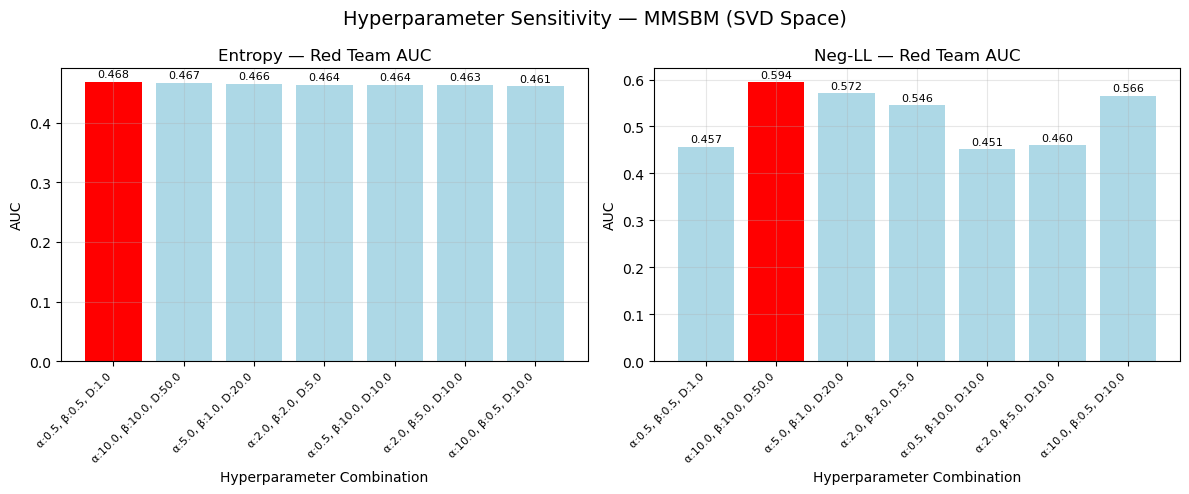


=== METRIC CORRELATIONS ===
             entropy_auc  nll_auc
entropy_auc        1.000   -0.062
nll_auc           -0.062    1.000

=== PARAMETER IMPACT ANALYSIS ===
Beta (edge density prior): (0.5,0.5) ~ uniform; (2,5) sparse; (10,10) centred at 0.5; ↑α denser, ↑β sparser.
Dirichlet scale (community prior): low = weak prior; high = closer to spectral/GMM initialisation.


In [57]:
# === MMSBM RUNNER ===
def run_mmsbm_with_params(X_subset, A_subset, labels_subset, 
                          beta_alpha, beta_beta, dirichlet_scale, K=9):
    """
    Fit an MMSBM with specified priors and return node-level scores + AUCs.
    labels_subset: binary (0 = normal, 1 = red team)
    """
    n_subset = len(X_subset)

    def safe_auc(y_true, scores):
        return roc_auc_score(y_true, scores) if len(np.unique(y_true)) > 1 else np.nan

    # Spectral-informed Dirichlet prior from GMM
    gmm = GaussianMixture(n_components=K, random_state=42).fit(X_subset)
    soft_memberships = gmm.predict_proba(X_subset)
    a_init = np.clip(soft_memberships * dirichlet_scale, 1e-3, None)

    # --- PyMC model ---
    with pm.Model() as model:
        pi = pm.Dirichlet('pi', a=a_init, shape=(n_subset, K))
        B  = pm.Beta('B', alpha=beta_alpha, beta=beta_beta, shape=(K, K))

        pi_i = pi.dimshuffle(0, 'x', 1)      # (i, j, k)
        pi_j = pi.dimshuffle('x', 0, 1)      # (i, j, l)

        # edge_probs[i,j] = sum_{k,l} pi_i[k] * B[k,l] * pi_j[l]
        edge_probs = pt.sum(pt.sum(
            pi_i.dimshuffle(0, 1, 2, 'x') *
            B.dimshuffle('x', 'x', 0, 1) *
            pi_j.dimshuffle(1, 0, 'x', 2),
            axis=3), axis=2)

        # remove self-edges and clamp for numerical stability
        edge_probs = edge_probs * (1 - pt.eye(n_subset))
        edge_probs = pt.clip(edge_probs, 1e-6, 1 - 1e-6)

        # observed should be integer 0/1
        A_obs = pm.Data('A_obs', (A_subset > 0).astype(np.int8))
        pm.Bernoulli('obs', p=edge_probs, observed=A_obs)

        approx = pm.fit(5000, method='advi', random_seed=42)
        trace  = approx.sample(200, random_seed=42)

    # Posterior means
    pi_mean = trace.posterior['pi'].mean(dim=["chain", "draw"]).values
    B_mean  = trace.posterior['B'].mean(dim=["chain", "draw"]).values

    # Renormalise rows defensively
    row_sums = pi_mean.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1.0
    pi_mean = pi_mean / row_sums

    # Entropy (normalised)
    entropy = -np.sum(pi_mean * np.log(np.maximum(pi_mean, 1e-12)), axis=1) / np.log(K)

    # Vectorised nodewise negative log-likelihood
    eps = 1e-6
    P = pi_mean @ B_mean @ pi_mean.T
    P = np.clip(P, eps, 1 - eps)
    A_bin = (A_subset > 0).astype(float)
    np.fill_diagonal(A_bin, 0.0)

    mask = ~np.eye(n_subset, dtype=bool)
    ll_matrix = A_bin * np.log(P) + (1 - A_bin) * np.log(1 - P)
    ll_matrix[~mask] = 0.0
    negative_ll = -ll_matrix.sum(axis=1)

    if not np.isfinite(entropy).all():
        raise ValueError("Non-finite values in entropy")
    if not np.isfinite(negative_ll).all():
        raise ValueError("Non-finite values in negative log-likelihood")

    return {
        'beta_alpha': beta_alpha,
        'beta_beta': beta_beta,
        'dirichlet_scale': dirichlet_scale,
        'entropy_auc': safe_auc(labels_subset, entropy),
        'nll_auc': safe_auc(labels_subset, negative_ll),
        'entropy': entropy,
        'negative_ll': negative_ll
    }

# === SUBSET CREATION ===
K = 9
subset_size   = 1200
redteam_count = 150

rng = np.random.default_rng(42)
red_idx    = np.where(anomaly_df['is_redteam'] == 1)[0]
nonred_idx = np.where(anomaly_df['is_redteam'] == 0)[0]
rng.shuffle(red_idx); rng.shuffle(nonred_idx)

subset_red     = red_idx[:min(redteam_count, len(red_idx))]
subset_nonred  = nonred_idx[:(subset_size - len(subset_red))]
subset_svd_idx = np.concatenate([subset_red, subset_nonred])
n_svd_subset   = len(subset_svd_idx)

X_svd_subset = X_svd[subset_svd_idx]
A_svd_subset = A[np.ix_(subset_svd_idx, subset_svd_idx)].astype(float)

# Optional: symmetrise for undirected MMSBM
# A_svd_subset = ((A_svd_subset > 0) | (A_svd_subset.T > 0)).astype(float)

np.fill_diagonal(A_svd_subset, 0.0)
labels_svd_subset = anomaly_df['is_redteam'].iloc[subset_svd_idx].astype(int).values

print("Subset (SVD) composition:")
print(f"  Red Team: {len(subset_red)}")
print(f"  Non-Red:  {len(subset_nonred)}")
print(f"  Total:    {n_svd_subset}")
print(f"  Subset density: {A_svd_subset.sum() / (n_svd_subset * (n_svd_subset - 1)):.4f}")

# === HYPERPARAMETER SENSITIVITY ===
param_combinations = [
    (2.0, 5.0, 10.0),
    (0.5, 0.5, 1.0),
    (10.0, 10.0, 50.0),
    (0.5, 10.0, 10.0),
    (10.0, 0.5, 10.0),
    (2.0, 2.0, 5.0),
    (5.0, 1.0, 20.0),
]

results = []
print("\nRunning hyperparameter sensitivity analysis...")
for alpha, beta, dscale in param_combinations:
    print(f"Testing: α={alpha}, β={beta}, D={dscale}")
    try:
        res = run_mmsbm_with_params(
            X_svd_subset, A_svd_subset, labels_svd_subset,
            alpha, beta, dscale, K=K
        )
        results.append(res)
    except Exception as e:
        print(f"  Failed: {e}")

results_df = pd.DataFrame(results)

# === RESULTS HANDLING & PLOTTING ===
if results_df.empty:
    print("\nNo successful runs — check input scaling, priors, or subset size.")
else:
    results_df_sorted = results_df.sort_values(by='entropy_auc', ascending=False).reset_index(drop=True)

    print("\n=== HYPERPARAMETER SENSITIVITY RESULTS ===")
    print(results_df_sorted.round(3).to_string(index=False))

    metrics = ['entropy_auc', 'nll_auc']
    titles  = ['Entropy — Red Team AUC', 'Neg-LL — Red Team AUC']

    print("\n=== BEST PARAMETERS FOR EACH METRIC ===")
    for metric in metrics:
        best_idx = results_df[metric].idxmax()
        best = results_df.loc[best_idx]
        label = 'Entropy AUC' if 'entropy' in metric else 'Neg-LL AUC'
        print(f"{label}: {best[metric]:.3f}")
        print(f"  β_alpha={best['beta_alpha']}, β_beta={best['beta_beta']}, D_scale={best['dirichlet_scale']}")

    # Bar plots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    for ax, metric, title in zip(axes, metrics, titles):
        vals = results_df_sorted[metric].values
        param_labels = [
            f"α:{row['beta_alpha']}, β:{row['beta_beta']}, D:{row['dirichlet_scale']}"
            for _, row in results_df_sorted.iterrows()
        ]
        bars = ax.bar(range(len(vals)), vals,
                      color=['red' if v == vals.max() else 'lightblue' for v in vals])
        ax.set_title(title)
        ax.set_ylabel('AUC')
        ax.set_xlabel('Hyperparameter Combination')
        ax.set_xticks(range(len(vals)))
        ax.set_xticklabels(param_labels, rotation=45, ha='right', fontsize=8)
        ax.grid(True, alpha=0.3)
        for j, b in enumerate(bars):
            h = b.get_height()
            ax.text(b.get_x() + b.get_width()/2., h + 0.005, f'{h:.3f}',
                    ha='center', va='bottom', fontsize=8)

    fig.suptitle("Hyperparameter Sensitivity — MMSBM (SVD Space)", fontsize=14)
    plt.tight_layout()
    plt.show()

    print("\n=== METRIC CORRELATIONS ===")
    print(results_df[metrics].corr().round(3))

print("\n=== PARAMETER IMPACT ANALYSIS ===")
print("Beta (edge density prior): (0.5,0.5) ~ uniform; (2,5) sparse; (10,10) centred at 0.5; ↑α denser, ↑β sparser.")
print("Dirichlet scale (community prior): low = weak prior; high = closer to spectral/GMM initialisation.")